In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
data_frame = pd.read_csv("./mnist_train.csv", sep=",", header=None)

In [5]:
data_frame.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
print(data_frame.loc[0:300,0])
print(',,,,,,,,,,,')
data_frame.loc[:, 1:] /= 255.0
print(data_frame.loc[0:300,0])

0      5
1      0
2      4
3      1
4      9
5      2
6      1
7      3
8      1
9      4
10     3
11     5
12     3
13     6
14     1
15     7
16     2
17     8
18     6
19     9
20     4
21     0
22     9
23     1
24     1
25     2
26     4
27     3
28     2
29     7
      ..
271    4
272    4
273    5
274    6
275    4
276    1
277    2
278    5
279    3
280    9
281    3
282    9
283    0
284    5
285    9
286    6
287    5
288    7
289    4
290    1
291    3
292    4
293    0
294    4
295    8
296    0
297    4
298    3
299    6
300    8
Name: 0, Length: 301, dtype: int64
,,,,,,,,,,,
0      5
1      0
2      4
3      1
4      9
5      2
6      1
7      3
8      1
9      4
10     3
11     5
12     3
13     6
14     1
15     7
16     2
17     8
18     6
19     9
20     4
21     0
22     9
23     1
24     1
25     2
26     4
27     3
28     2
29     7
      ..
271    4
272    4
273    5
274    6
275    4
276    1
277    2
278    5
279    3
280    9
281    3
282    9
283    0
284    5

In [7]:
print(data_frame.loc)

In [8]:
data=data_frame.as_matrix()

data[0:300,0]

C:\Users\Paulina\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([5., 0., 4., 1., 9., 2., 1., 3., 1., 4., 3., 5., 3., 6., 1., 7., 2.,
       8., 6., 9., 4., 0., 9., 1., 1., 2., 4., 3., 2., 7., 3., 8., 6., 9.,
       0., 5., 6., 0., 7., 6., 1., 8., 7., 9., 3., 9., 8., 5., 9., 3., 3.,
       0., 7., 4., 9., 8., 0., 9., 4., 1., 4., 4., 6., 0., 4., 5., 6., 1.,
       0., 0., 1., 7., 1., 6., 3., 0., 2., 1., 1., 7., 9., 0., 2., 6., 7.,
       8., 3., 9., 0., 4., 6., 7., 4., 6., 8., 0., 7., 8., 3., 1., 5., 7.,
       1., 7., 1., 1., 6., 3., 0., 2., 9., 3., 1., 1., 0., 4., 9., 2., 0.,
       0., 2., 0., 2., 7., 1., 8., 6., 4., 1., 6., 3., 4., 5., 9., 1., 3.,
       3., 8., 5., 4., 7., 7., 4., 2., 8., 5., 8., 6., 7., 3., 4., 6., 1.,
       9., 9., 6., 0., 3., 7., 2., 8., 2., 9., 4., 4., 6., 4., 9., 7., 0.,
       9., 2., 9., 5., 1., 5., 9., 1., 2., 3., 2., 3., 5., 9., 1., 7., 6.,
       2., 8., 2., 2., 5., 0., 7., 4., 9., 7., 8., 3., 2., 1., 1., 8., 3.,
       6., 1., 0., 3., 1., 0., 0., 1., 7., 2., 7., 3., 0., 4., 6., 5., 2.,
       6., 4., 7., 1., 8.

In [9]:
image=data[0,1:].reshape((28,28))
data[0,0]

5.0

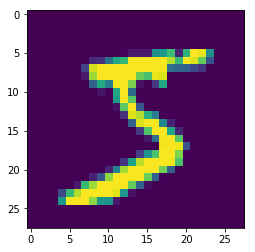

In [10]:
plt.imshow(image)
plt.show()

In [11]:
#create validation set
#shuffle(data)
train_data=data[0:50000,:]
val_data=data[50000:,:]


In [13]:
import numpy as np
from random import shuffle
from sklearn.metrics import mean_squared_error

class Network(object):
    
    def __init__(self, train_data, hidden_layer_neurons_num, epochs, learning_rate = 0.05):
        self.number_of_classes = 10
        self.epochs=epochs
        self.train_data = train_data
        self.learning_rate = learning_rate
        train_data_without_labels = train_data[:,1:]
        self.input_neurons_num = train_data_without_labels.shape[0] \
            if len(train_data_without_labels.shape) == 1 \
            else train_data_without_labels.shape[1]
        self.neurons_num_per_layer = [self.input_neurons_num] + hidden_layer_neurons_num + [self.number_of_classes]
        self.layers_num = len(self.neurons_num_per_layer)
        self.activation_functions = [lambda x: self.sigmoid_function(x)] * (self.layers_num - 2) + \
            [lambda x: self.softmax_function(x)] 
        self.weight_list = [np.random.randn(next_layer_num, current_layer_num) \
                       for (current_layer_num, next_layer_num) in \
                            zip(self.neurons_num_per_layer, self.neurons_num_per_layer[1:])]
        self.bias_list = [np.random.randn(layer_num,1) for layer_num in self.neurons_num_per_layer[1:]]
        
    
    def main(self, batch_size):
        print(val_data.shape)
        avg_mse=np.zeros(self.epochs) 
        avg_val=np.zeros(self.epochs) 
        for epoch in range(self.epochs):
            #shuffle(self.train_data)
            train_batches = self.create_train_batches(batch_size)
            mse1=self.feed_forward(train_batches)
            avg_mse[epoch]=mse1/self.train_data.shape[0]
            _,mse_val=self.predict(val_data,False)
            avg_val[epoch]=mse_val/val_data.shape[0]
            
        return avg_mse, avg_val 
                

    #uwaga feedforward można zrobić macierzowo, ale backprop trzeba dla pojedynczych rekordów
    def feed_forward(self, train_batches):
        mse = 0
        for train_batch in train_batches:
            labels = self.one_hot_encoded(train_batch[:, 0])
            train_batch_features = train_batch[:, 1:]
            batch_size=train_batch_features.shape[0]
        
            #forward
            grad_w=[0] * (self.layers_num - 1)
            grad_b=[0] * (self.layers_num - 1)
            
            for i in range (len(train_batch)): #rekord
                #print(labels[:,i])
                u = []
                layer_output = [train_batch_features[i,:]]
                for activation_function, w, b in zip(self.activation_functions, \
                                                 self.weight_list, \
                                                 self.bias_list):
                    a=np.matmul(w,layer_output[-1])
                    u.append(a.reshape(a.shape[0], 1) + b)
                    layer_output.append(activation_function(u[-1]))
                
                mse+=mean_squared_error(layer_output[-1],labels[:,i].reshape(10,1))
                
                #backprop
                label=labels[:,i].reshape(10,1)
                delta = [(layer_output[-1] - label) * self.softmax_derivative(layer_output[-1], u[-1])] 
                for layer_num in reversed(range(1, self.layers_num-1)):
                    delta.append(np.matmul(self.weight_list[layer_num].T, delta[-1])*\
                                 self.sigmoid_derivative(u[layer_num-1])) 
                delta = list(reversed(delta))
            
                tmp_grad_w = [np.matmul(delta[0], train_batch_features[i,:].reshape(784,1).T)]
                for activ, d, _u in zip(self.activation_functions, delta[1:], u):
                    tmp_grad_w.append(np.matmul(d,activ(_u).T))
                    
                grad_w = [a + b for a, b in zip(grad_w, tmp_grad_w)]
                grad_b= [a + b for a, b in zip(delta, grad_b)]
                
            new_weight_list = [w - (self.learning_rate * gw / batch_size) \
                               for w, gw in zip(self.weight_list, grad_w)]
            self.weight_list = new_weight_list
            
            new_bias_list = [ b - (self.learning_rate * gb / batch_size) \
                             for b, gb in zip(self.bias_list, grad_b)]
            self.bias_list = new_bias_list
        return mse
    
    def predict(self, test_batch, flag):
        labels = self.one_hot_encoded(test_batch[:, 0])
        #print(labels)
        test_batch_features = test_batch[:, 1:]
        batch_size=test_batch_features.shape[0]
        res = []
        diff=0
        stat=np.zeros((test_batch.shape[0],2))
        for i in range(len(test_batch)):
            layer_output = test_batch_features[i,:]
            for activation_function, w, b in zip(self.activation_functions, \
                                                 self.weight_list, \
                                                 self.bias_list):
                a = np.matmul(w,layer_output)
                u = a.reshape(a.shape[0], 1) + b
                layer_output = activation_function(u)
    
            res.append(layer_output)
            #print(labels[:,i])
            if flag==True:
                print("label: {0}, wanted: {1}".format(np.argmax(layer_output), np.argmax(labels[:,i])))
                stat[i,0]=np.argmax(layer_output)
                stat[i,1]=np.argmax(labels[:,i])
            #print("label: {0}".format((layer_output)))
            
            diff+=mean_squared_error(layer_output, labels[:,i])
        return (stat,diff)
            
    def softmax_derivative(self, probabilities, u):
        diff_output=np.zeros([self.number_of_classes, self.number_of_classes])
        for row in range (diff_output.shape[0]):
            for col in range (diff_output.shape[1]):
                if (col==row):
                    diff_output[row,col]=probabilities[row,0]*(1-probabilities[col,0])
                else:
                    diff_output[row,col]=-probabilities[row,0]*probabilities[col,0]
        return np.matmul(diff_output,u)
                             
    def sigmoid_derivative(self, u):
        sigmoid_value = self.sigmoid_function(u)
        diff_output=sigmoid_value*(1-sigmoid_value)
        return diff_output
      
    #poprawić, dodać relu    
    def tanh_derivative(self, u):
        diff_output=1-(u)^2
        return diff_output
         
    def create_train_batches(self, batch_size):
        rows_num = self.train_data.shape[0]
        n = int(np.ceil(rows_num / batch_size))
        return [self.train_data[(i * batch_size):min((i + 1) * batch_size, rows_num)] for i in range(n)]
    
    def one_hot_encoded(self, train_labels):
        train_labels = train_labels.astype(int)
        res = np.zeros((self.number_of_classes, train_labels.shape[0]))
        res[train_labels, np.arange(res.shape[1])] = 1
        return res
        
    def sigmoid_function(self, x):
        return 1 / (1 + np.exp(-x))
    
    def softmax_function(self, x):
        return np.exp(x) / np.sum(np.exp(x)) 
        


In [41]:
net = Network(train_data, [32], 5)

In [15]:
[matrix.shape for matrix in net.weight_list]

[(100, 784), (90, 100), (10, 90)]

In [16]:
net.input_neurons_num

784

In [17]:
net.bias_list[2].shape

(10, 1)

In [42]:
train_mse,val_mse = net.main(128)

(10000, 785)


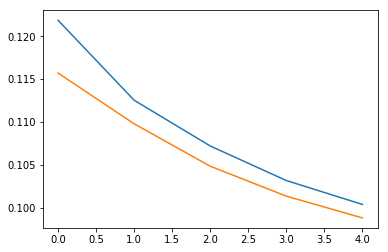

In [43]:
import matplotlib.pyplot as plt
plt.plot(train_mse)
plt.plot(val_mse)
plt.show()

In [47]:
stat, _=net.predict(train_data, True)

label: 1, wanted: 5
label: 0, wanted: 0
label: 5, wanted: 4
label: 1, wanted: 1
label: 2, wanted: 9
label: 7, wanted: 2
label: 5, wanted: 1
label: 8, wanted: 3
label: 5, wanted: 1
label: 4, wanted: 4
label: 9, wanted: 3
label: 3, wanted: 5
label: 2, wanted: 3
label: 7, wanted: 6
label: 3, wanted: 1
label: 4, wanted: 7
label: 2, wanted: 2
label: 1, wanted: 8
label: 7, wanted: 6
label: 3, wanted: 9
label: 5, wanted: 4
label: 1, wanted: 0
label: 4, wanted: 9
label: 6, wanted: 1
label: 7, wanted: 1
label: 9, wanted: 2
label: 9, wanted: 4
label: 1, wanted: 3
label: 1, wanted: 2
label: 7, wanted: 7
label: 0, wanted: 3
label: 0, wanted: 8
label: 8, wanted: 6
label: 3, wanted: 9
label: 1, wanted: 0
label: 2, wanted: 5
label: 0, wanted: 6
label: 7, wanted: 0
label: 1, wanted: 7
label: 0, wanted: 6
label: 0, wanted: 1
label: 1, wanted: 8
label: 3, wanted: 7
label: 3, wanted: 9
label: 2, wanted: 3
label: 1, wanted: 9
label: 6, wanted: 8
label: 8, wanted: 5
label: 2, wanted: 9
label: 1, wanted: 3


label: 6, wanted: 5
label: 3, wanted: 8
label: 1, wanted: 6
label: 4, wanted: 5
label: 7, wanted: 9
label: 4, wanted: 7
label: 2, wanted: 2
label: 2, wanted: 5
label: 0, wanted: 0
label: 1, wanted: 8
label: 5, wanted: 5
label: 1, wanted: 1
label: 3, wanted: 1
label: 0, wanted: 0
label: 1, wanted: 9
label: 1, wanted: 1
label: 9, wanted: 8
label: 4, wanted: 6
label: 8, wanted: 7
label: 0, wanted: 0
label: 5, wanted: 9
label: 2, wanted: 3
label: 9, wanted: 0
label: 0, wanted: 8
label: 1, wanted: 8
label: 1, wanted: 9
label: 4, wanted: 6
label: 8, wanted: 7
label: 4, wanted: 8
label: 1, wanted: 4
label: 3, wanted: 7
label: 3, wanted: 5
label: 0, wanted: 9
label: 7, wanted: 2
label: 9, wanted: 6
label: 0, wanted: 7
label: 1, wanted: 4
label: 3, wanted: 5
label: 1, wanted: 9
label: 7, wanted: 2
label: 2, wanted: 3
label: 1, wanted: 1
label: 0, wanted: 6
label: 4, wanted: 3
label: 5, wanted: 9
label: 7, wanted: 2
label: 1, wanted: 2
label: 0, wanted: 5
label: 4, wanted: 6
label: 9, wanted: 8


label: 2, wanted: 2
label: 7, wanted: 4
label: 2, wanted: 0
label: 8, wanted: 7
label: 4, wanted: 5
label: 5, wanted: 6
label: 1, wanted: 5
label: 4, wanted: 0
label: 7, wanted: 9
label: 0, wanted: 8
label: 0, wanted: 6
label: 6, wanted: 1
label: 1, wanted: 9
label: 8, wanted: 7
label: 2, wanted: 5
label: 8, wanted: 7
label: 4, wanted: 5
label: 1, wanted: 1
label: 2, wanted: 1
label: 7, wanted: 3
label: 7, wanted: 0
label: 7, wanted: 2
label: 6, wanted: 0
label: 1, wanted: 3
label: 9, wanted: 8
label: 6, wanted: 1
label: 6, wanted: 6
label: 7, wanted: 4
label: 1, wanted: 6
label: 2, wanted: 2
label: 8, wanted: 6
label: 7, wanted: 4
label: 0, wanted: 8
label: 1, wanted: 8
label: 3, wanted: 1
label: 4, wanted: 4
label: 4, wanted: 4
label: 8, wanted: 7
label: 3, wanted: 1
label: 5, wanted: 2
label: 1, wanted: 2
label: 4, wanted: 3
label: 1, wanted: 9
label: 5, wanted: 6
label: 2, wanted: 4
label: 1, wanted: 9
label: 1, wanted: 5
label: 5, wanted: 6
label: 4, wanted: 2
label: 5, wanted: 3


label: 1, wanted: 7
label: 4, wanted: 9
label: 8, wanted: 5
label: 7, wanted: 6
label: 2, wanted: 5
label: 8, wanted: 2
label: 2, wanted: 3
label: 8, wanted: 0
label: 9, wanted: 4
label: 2, wanted: 1
label: 1, wanted: 4
label: 8, wanted: 0
label: 8, wanted: 5
label: 0, wanted: 6
label: 2, wanted: 1
label: 7, wanted: 2
label: 0, wanted: 6
label: 9, wanted: 3
label: 7, wanted: 4
label: 1, wanted: 8
label: 2, wanted: 5
label: 9, wanted: 9
label: 0, wanted: 5
label: 8, wanted: 0
label: 1, wanted: 2
label: 9, wanted: 7
label: 7, wanted: 5
label: 7, wanted: 2
label: 1, wanted: 9
label: 9, wanted: 3
label: 8, wanted: 4
label: 2, wanted: 4
label: 9, wanted: 0
label: 4, wanted: 5
label: 1, wanted: 2
label: 4, wanted: 5
label: 8, wanted: 5
label: 2, wanted: 2
label: 6, wanted: 9
label: 3, wanted: 8
label: 3, wanted: 3
label: 2, wanted: 5
label: 4, wanted: 2
label: 8, wanted: 4
label: 2, wanted: 4
label: 7, wanted: 6
label: 6, wanted: 7
label: 0, wanted: 6
label: 4, wanted: 4
label: 4, wanted: 6


label: 1, wanted: 1
label: 1, wanted: 5
label: 2, wanted: 9
label: 8, wanted: 0
label: 6, wanted: 2
label: 1, wanted: 1
label: 1, wanted: 1
label: 6, wanted: 2
label: 6, wanted: 8
label: 1, wanted: 3
label: 4, wanted: 8
label: 6, wanted: 4
label: 0, wanted: 0
label: 4, wanted: 5
label: 0, wanted: 5
label: 0, wanted: 6
label: 7, wanted: 5
label: 1, wanted: 7
label: 4, wanted: 7
label: 1, wanted: 8
label: 2, wanted: 0
label: 8, wanted: 9
label: 4, wanted: 6
label: 4, wanted: 0
label: 3, wanted: 9
label: 1, wanted: 1
label: 6, wanted: 8
label: 8, wanted: 2
label: 3, wanted: 3
label: 9, wanted: 3
label: 4, wanted: 4
label: 1, wanted: 4
label: 9, wanted: 3
label: 4, wanted: 5
label: 1, wanted: 5
label: 4, wanted: 6
label: 5, wanted: 5
label: 4, wanted: 7
label: 3, wanted: 1
label: 9, wanted: 8
label: 2, wanted: 8
label: 4, wanted: 9
label: 8, wanted: 0
label: 0, wanted: 0
label: 0, wanted: 2
label: 1, wanted: 1
label: 8, wanted: 6
label: 7, wanted: 2
label: 0, wanted: 7
label: 1, wanted: 3


label: 3, wanted: 9
label: 9, wanted: 9
label: 0, wanted: 8
label: 1, wanted: 8
label: 8, wanted: 4
label: 9, wanted: 0
label: 0, wanted: 4
label: 4, wanted: 5
label: 4, wanted: 3
label: 8, wanted: 6
label: 2, wanted: 2
label: 0, wanted: 0
label: 9, wanted: 3
label: 1, wanted: 1
label: 4, wanted: 2
label: 9, wanted: 0
label: 0, wanted: 9
label: 0, wanted: 2
label: 9, wanted: 2
label: 0, wanted: 5
label: 8, wanted: 5
label: 9, wanted: 3
label: 8, wanted: 3
label: 1, wanted: 5
label: 2, wanted: 4
label: 7, wanted: 3
label: 5, wanted: 8
label: 9, wanted: 8
label: 0, wanted: 8
label: 9, wanted: 0
label: 3, wanted: 7
label: 7, wanted: 0
label: 4, wanted: 4
label: 7, wanted: 5
label: 3, wanted: 9
label: 7, wanted: 4
label: 6, wanted: 0
label: 1, wanted: 3
label: 1, wanted: 6
label: 7, wanted: 4
label: 0, wanted: 0
label: 0, wanted: 1
label: 2, wanted: 9
label: 2, wanted: 5
label: 0, wanted: 6
label: 1, wanted: 3
label: 9, wanted: 4
label: 1, wanted: 0
label: 0, wanted: 2
label: 9, wanted: 8


label: 0, wanted: 6
label: 0, wanted: 6
label: 2, wanted: 7
label: 0, wanted: 4
label: 9, wanted: 8
label: 6, wanted: 1
label: 4, wanted: 4
label: 7, wanted: 2
label: 5, wanted: 4
label: 7, wanted: 4
label: 1, wanted: 8
label: 6, wanted: 1
label: 6, wanted: 2
label: 1, wanted: 5
label: 4, wanted: 0
label: 6, wanted: 1
label: 2, wanted: 2
label: 4, wanted: 9
label: 4, wanted: 8
label: 4, wanted: 3
label: 8, wanted: 5
label: 5, wanted: 2
label: 3, wanted: 7
label: 4, wanted: 0
label: 0, wanted: 4
label: 0, wanted: 0
label: 4, wanted: 9
label: 4, wanted: 2
label: 5, wanted: 7
label: 4, wanted: 9
label: 3, wanted: 4
label: 1, wanted: 3
label: 8, wanted: 5
label: 9, wanted: 6
label: 8, wanted: 4
label: 1, wanted: 0
label: 9, wanted: 9
label: 2, wanted: 1
label: 0, wanted: 8
label: 2, wanted: 2
label: 1, wanted: 1
label: 8, wanted: 3
label: 5, wanted: 7
label: 2, wanted: 4
label: 6, wanted: 2
label: 9, wanted: 5
label: 1, wanted: 2
label: 0, wanted: 6
label: 5, wanted: 7
label: 5, wanted: 7


label: 4, wanted: 2
label: 2, wanted: 3
label: 8, wanted: 3
label: 4, wanted: 0
label: 0, wanted: 4
label: 0, wanted: 2
label: 5, wanted: 5
label: 5, wanted: 5
label: 7, wanted: 6
label: 2, wanted: 3
label: 1, wanted: 7
label: 1, wanted: 2
label: 1, wanted: 8
label: 0, wanted: 5
label: 8, wanted: 9
label: 4, wanted: 2
label: 1, wanted: 0
label: 5, wanted: 1
label: 7, wanted: 1
label: 7, wanted: 8
label: 5, wanted: 2
label: 9, wanted: 9
label: 1, wanted: 3
label: 8, wanted: 1
label: 7, wanted: 4
label: 1, wanted: 1
label: 5, wanted: 5
label: 5, wanted: 7
label: 0, wanted: 6
label: 1, wanted: 4
label: 8, wanted: 7
label: 5, wanted: 7
label: 0, wanted: 8
label: 1, wanted: 3
label: 1, wanted: 9
label: 2, wanted: 3
label: 0, wanted: 0
label: 8, wanted: 5
label: 7, wanted: 1
label: 7, wanted: 3
label: 4, wanted: 2
label: 6, wanted: 0
label: 4, wanted: 3
label: 1, wanted: 0
label: 4, wanted: 4
label: 2, wanted: 0
label: 8, wanted: 7
label: 7, wanted: 4
label: 1, wanted: 8
label: 9, wanted: 8


label: 1, wanted: 1
label: 5, wanted: 2
label: 1, wanted: 8
label: 8, wanted: 4
label: 2, wanted: 3
label: 2, wanted: 9
label: 5, wanted: 7
label: 7, wanted: 4
label: 7, wanted: 9
label: 9, wanted: 3
label: 0, wanted: 3
label: 1, wanted: 8
label: 4, wanted: 0
label: 6, wanted: 6
label: 1, wanted: 9
label: 1, wanted: 6
label: 8, wanted: 4
label: 9, wanted: 9
label: 0, wanted: 4
label: 1, wanted: 0
label: 1, wanted: 0
label: 0, wanted: 6
label: 2, wanted: 7
label: 8, wanted: 3
label: 5, wanted: 4
label: 5, wanted: 1
label: 7, wanted: 2
label: 9, wanted: 2
label: 1, wanted: 9
label: 3, wanted: 7
label: 4, wanted: 8
label: 9, wanted: 3
label: 2, wanted: 7
label: 1, wanted: 4
label: 4, wanted: 2
label: 4, wanted: 1
label: 2, wanted: 7
label: 5, wanted: 6
label: 0, wanted: 8
label: 4, wanted: 5
label: 8, wanted: 9
label: 6, wanted: 0
label: 1, wanted: 3
label: 1, wanted: 6
label: 1, wanted: 1
label: 3, wanted: 1
label: 5, wanted: 4
label: 7, wanted: 9
label: 1, wanted: 6
label: 9, wanted: 3


label: 4, wanted: 6
label: 3, wanted: 7
label: 2, wanted: 7
label: 1, wanted: 8
label: 1, wanted: 2
label: 0, wanted: 9
label: 5, wanted: 2
label: 1, wanted: 7
label: 4, wanted: 6
label: 4, wanted: 4
label: 5, wanted: 4
label: 9, wanted: 7
label: 4, wanted: 6
label: 9, wanted: 7
label: 5, wanted: 1
label: 2, wanted: 3
label: 4, wanted: 4
label: 1, wanted: 9
label: 1, wanted: 2
label: 0, wanted: 8
label: 0, wanted: 2
label: 1, wanted: 8
label: 3, wanted: 0
label: 1, wanted: 3
label: 8, wanted: 8
label: 1, wanted: 1
label: 0, wanted: 3
label: 0, wanted: 5
label: 6, wanted: 0
label: 7, wanted: 8
label: 9, wanted: 5
label: 4, wanted: 2
label: 4, wanted: 8
label: 3, wanted: 7
label: 0, wanted: 8
label: 4, wanted: 6
label: 4, wanted: 7
label: 5, wanted: 1
label: 2, wanted: 8
label: 4, wanted: 5
label: 9, wanted: 9
label: 6, wanted: 2
label: 1, wanted: 3
label: 7, wanted: 6
label: 6, wanted: 9
label: 1, wanted: 4
label: 4, wanted: 9
label: 1, wanted: 1
label: 1, wanted: 3
label: 0, wanted: 8


label: 5, wanted: 5
label: 0, wanted: 7
label: 6, wanted: 1
label: 1, wanted: 5
label: 4, wanted: 9
label: 3, wanted: 1
label: 3, wanted: 9
label: 6, wanted: 2
label: 1, wanted: 0
label: 0, wanted: 5
label: 3, wanted: 9
label: 8, wanted: 5
label: 5, wanted: 0
label: 5, wanted: 4
label: 4, wanted: 5
label: 1, wanted: 3
label: 4, wanted: 9
label: 9, wanted: 9
label: 6, wanted: 1
label: 4, wanted: 0
label: 5, wanted: 7
label: 0, wanted: 9
label: 4, wanted: 2
label: 0, wanted: 9
label: 4, wanted: 2
label: 2, wanted: 5
label: 0, wanted: 3
label: 0, wanted: 2
label: 4, wanted: 3
label: 9, wanted: 9
label: 4, wanted: 2
label: 7, wanted: 2
label: 7, wanted: 0
label: 8, wanted: 6
label: 4, wanted: 9
label: 5, wanted: 5
label: 4, wanted: 0
label: 4, wanted: 0
label: 4, wanted: 6
label: 2, wanted: 9
label: 5, wanted: 1
label: 7, wanted: 5
label: 8, wanted: 7
label: 8, wanted: 7
label: 4, wanted: 5
label: 4, wanted: 4
label: 4, wanted: 0
label: 2, wanted: 4
label: 8, wanted: 3
label: 7, wanted: 7


label: 0, wanted: 5
label: 2, wanted: 5
label: 6, wanted: 6
label: 0, wanted: 6
label: 5, wanted: 7
label: 1, wanted: 1
label: 3, wanted: 7
label: 1, wanted: 8
label: 1, wanted: 1
label: 6, wanted: 6
label: 4, wanted: 5
label: 2, wanted: 4
label: 0, wanted: 0
label: 6, wanted: 6
label: 5, wanted: 2
label: 2, wanted: 0
label: 8, wanted: 6
label: 1, wanted: 9
label: 2, wanted: 4
label: 2, wanted: 2
label: 1, wanted: 8
label: 0, wanted: 6
label: 0, wanted: 5
label: 2, wanted: 4
label: 3, wanted: 3
label: 5, wanted: 3
label: 7, wanted: 3
label: 4, wanted: 9
label: 7, wanted: 0
label: 7, wanted: 3
label: 3, wanted: 3
label: 4, wanted: 0
label: 0, wanted: 7
label: 4, wanted: 0
label: 7, wanted: 5
label: 5, wanted: 5
label: 1, wanted: 2
label: 6, wanted: 2
label: 8, wanted: 4
label: 0, wanted: 5
label: 6, wanted: 0
label: 7, wanted: 8
label: 1, wanted: 9
label: 0, wanted: 8
label: 4, wanted: 1
label: 1, wanted: 8
label: 1, wanted: 6
label: 9, wanted: 9
label: 9, wanted: 9
label: 5, wanted: 4


label: 1, wanted: 1
label: 0, wanted: 4
label: 1, wanted: 2
label: 2, wanted: 3
label: 2, wanted: 3
label: 8, wanted: 3
label: 7, wanted: 4
label: 9, wanted: 5
label: 3, wanted: 5
label: 9, wanted: 9
label: 6, wanted: 6
label: 6, wanted: 3
label: 8, wanted: 7
label: 4, wanted: 7
label: 5, wanted: 8
label: 6, wanted: 6
label: 0, wanted: 9
label: 8, wanted: 8
label: 0, wanted: 0
label: 8, wanted: 0
label: 6, wanted: 1
label: 5, wanted: 6
label: 4, wanted: 2
label: 0, wanted: 5
label: 8, wanted: 3
label: 7, wanted: 8
label: 1, wanted: 5
label: 1, wanted: 8
label: 4, wanted: 6
label: 1, wanted: 5
label: 2, wanted: 7
label: 9, wanted: 9
label: 2, wanted: 4
label: 1, wanted: 1
label: 4, wanted: 0
label: 2, wanted: 2
label: 4, wanted: 7
label: 2, wanted: 2
label: 6, wanted: 2
label: 0, wanted: 5
label: 2, wanted: 9
label: 1, wanted: 8
label: 8, wanted: 4
label: 0, wanted: 5
label: 1, wanted: 2
label: 6, wanted: 9
label: 4, wanted: 9
label: 9, wanted: 2
label: 7, wanted: 8
label: 4, wanted: 0


label: 1, wanted: 1
label: 9, wanted: 3
label: 0, wanted: 9
label: 5, wanted: 7
label: 6, wanted: 3
label: 8, wanted: 9
label: 2, wanted: 7
label: 1, wanted: 1
label: 7, wanted: 4
label: 3, wanted: 7
label: 4, wanted: 7
label: 8, wanted: 7
label: 0, wanted: 0
label: 0, wanted: 4
label: 4, wanted: 9
label: 1, wanted: 6
label: 0, wanted: 0
label: 4, wanted: 0
label: 4, wanted: 0
label: 1, wanted: 4
label: 1, wanted: 3
label: 4, wanted: 7
label: 4, wanted: 7
label: 5, wanted: 6
label: 8, wanted: 9
label: 1, wanted: 9
label: 1, wanted: 2
label: 0, wanted: 5
label: 0, wanted: 0
label: 1, wanted: 0
label: 1, wanted: 1
label: 0, wanted: 7
label: 1, wanted: 0
label: 4, wanted: 0
label: 1, wanted: 1
label: 1, wanted: 0
label: 8, wanted: 0
label: 4, wanted: 6
label: 4, wanted: 4
label: 9, wanted: 5
label: 4, wanted: 0
label: 3, wanted: 5
label: 7, wanted: 4
label: 1, wanted: 3
label: 1, wanted: 7
label: 6, wanted: 6
label: 8, wanted: 9
label: 3, wanted: 7
label: 3, wanted: 2
label: 1, wanted: 2


label: 0, wanted: 9
label: 9, wanted: 9
label: 4, wanted: 5
label: 7, wanted: 9
label: 3, wanted: 8
label: 6, wanted: 0
label: 0, wanted: 8
label: 6, wanted: 6
label: 0, wanted: 4
label: 1, wanted: 5
label: 2, wanted: 9
label: 6, wanted: 2
label: 7, wanted: 0
label: 9, wanted: 4
label: 4, wanted: 8
label: 1, wanted: 9
label: 4, wanted: 9
label: 6, wanted: 2
label: 4, wanted: 8
label: 4, wanted: 7
label: 1, wanted: 0
label: 4, wanted: 0
label: 2, wanted: 1
label: 4, wanted: 3
label: 1, wanted: 2
label: 1, wanted: 9
label: 7, wanted: 4
label: 4, wanted: 3
label: 0, wanted: 5
label: 7, wanted: 4
label: 0, wanted: 6
label: 0, wanted: 3
label: 1, wanted: 7
label: 5, wanted: 4
label: 1, wanted: 8
label: 2, wanted: 6
label: 1, wanted: 9
label: 2, wanted: 1
label: 1, wanted: 0
label: 2, wanted: 8
label: 3, wanted: 1
label: 1, wanted: 6
label: 0, wanted: 4
label: 4, wanted: 5
label: 1, wanted: 5
label: 2, wanted: 2
label: 7, wanted: 6
label: 6, wanted: 0
label: 1, wanted: 7
label: 7, wanted: 9


label: 9, wanted: 3
label: 3, wanted: 1
label: 4, wanted: 4
label: 6, wanted: 0
label: 1, wanted: 6
label: 1, wanted: 1
label: 3, wanted: 8
label: 5, wanted: 4
label: 1, wanted: 9
label: 0, wanted: 6
label: 6, wanted: 2
label: 1, wanted: 7
label: 1, wanted: 1
label: 8, wanted: 9
label: 8, wanted: 7
label: 0, wanted: 8
label: 4, wanted: 4
label: 8, wanted: 0
label: 4, wanted: 5
label: 0, wanted: 7
label: 6, wanted: 2
label: 1, wanted: 4
label: 5, wanted: 5
label: 0, wanted: 9
label: 4, wanted: 2
label: 9, wanted: 7
label: 1, wanted: 1
label: 1, wanted: 8
label: 4, wanted: 2
label: 0, wanted: 6
label: 0, wanted: 9
label: 6, wanted: 4
label: 9, wanted: 3
label: 0, wanted: 5
label: 1, wanted: 9
label: 7, wanted: 6
label: 1, wanted: 2
label: 0, wanted: 5
label: 6, wanted: 2
label: 7, wanted: 4
label: 2, wanted: 5
label: 2, wanted: 2
label: 7, wanted: 8
label: 7, wanted: 4
label: 8, wanted: 7
label: 0, wanted: 3
label: 1, wanted: 4
label: 5, wanted: 6
label: 8, wanted: 7
label: 8, wanted: 9


label: 0, wanted: 8
label: 8, wanted: 9
label: 4, wanted: 0
label: 1, wanted: 6
label: 0, wanted: 4
label: 2, wanted: 7
label: 9, wanted: 7
label: 6, wanted: 9
label: 9, wanted: 7
label: 9, wanted: 4
label: 0, wanted: 6
label: 8, wanted: 4
label: 1, wanted: 3
label: 4, wanted: 0
label: 2, wanted: 5
label: 4, wanted: 5
label: 0, wanted: 6
label: 0, wanted: 9
label: 4, wanted: 6
label: 2, wanted: 2
label: 1, wanted: 0
label: 6, wanted: 1
label: 0, wanted: 7
label: 1, wanted: 8
label: 1, wanted: 3
label: 2, wanted: 5
label: 3, wanted: 5
label: 9, wanted: 3
label: 2, wanted: 4
label: 0, wanted: 3
label: 6, wanted: 2
label: 5, wanted: 0
label: 6, wanted: 4
label: 2, wanted: 3
label: 6, wanted: 1
label: 3, wanted: 7
label: 2, wanted: 8
label: 1, wanted: 2
label: 1, wanted: 3
label: 9, wanted: 8
label: 4, wanted: 5
label: 1, wanted: 8
label: 5, wanted: 6
label: 1, wanted: 8
label: 5, wanted: 5
label: 9, wanted: 8
label: 7, wanted: 2
label: 1, wanted: 1
label: 0, wanted: 0
label: 2, wanted: 6


label: 8, wanted: 7
label: 6, wanted: 0
label: 7, wanted: 1
label: 4, wanted: 3
label: 7, wanted: 9
label: 4, wanted: 4
label: 1, wanted: 8
label: 9, wanted: 7
label: 4, wanted: 0
label: 2, wanted: 2
label: 0, wanted: 6
label: 4, wanted: 2
label: 0, wanted: 9
label: 0, wanted: 2
label: 0, wanted: 4
label: 5, wanted: 7
label: 7, wanted: 9
label: 1, wanted: 3
label: 4, wanted: 9
label: 4, wanted: 9
label: 5, wanted: 6
label: 3, wanted: 1
label: 1, wanted: 2
label: 5, wanted: 1
label: 1, wanted: 3
label: 6, wanted: 4
label: 8, wanted: 7
label: 2, wanted: 9
label: 7, wanted: 1
label: 9, wanted: 9
label: 2, wanted: 9
label: 7, wanted: 8
label: 2, wanted: 2
label: 9, wanted: 3
label: 1, wanted: 2
label: 4, wanted: 6
label: 5, wanted: 5
label: 1, wanted: 6
label: 7, wanted: 3
label: 4, wanted: 6
label: 8, wanted: 7
label: 9, wanted: 7
label: 1, wanted: 8
label: 8, wanted: 0
label: 4, wanted: 0
label: 0, wanted: 4
label: 1, wanted: 1
label: 6, wanted: 4
label: 6, wanted: 2
label: 0, wanted: 6


label: 8, wanted: 7
label: 1, wanted: 8
label: 2, wanted: 3
label: 0, wanted: 9
label: 3, wanted: 7
label: 7, wanted: 3
label: 9, wanted: 9
label: 4, wanted: 8
label: 6, wanted: 0
label: 4, wanted: 0
label: 2, wanted: 2
label: 8, wanted: 7
label: 1, wanted: 2
label: 1, wanted: 1
label: 9, wanted: 3
label: 4, wanted: 0
label: 1, wanted: 8
label: 1, wanted: 7
label: 1, wanted: 0
label: 0, wanted: 6
label: 4, wanted: 3
label: 4, wanted: 9
label: 0, wanted: 6
label: 0, wanted: 0
label: 9, wanted: 3
label: 7, wanted: 1
label: 7, wanted: 0
label: 4, wanted: 0
label: 1, wanted: 0
label: 3, wanted: 0
label: 2, wanted: 3
label: 0, wanted: 8
label: 0, wanted: 6
label: 1, wanted: 3
label: 2, wanted: 3
label: 1, wanted: 4
label: 6, wanted: 6
label: 1, wanted: 3
label: 6, wanted: 6
label: 7, wanted: 1
label: 8, wanted: 3
label: 3, wanted: 5
label: 7, wanted: 0
label: 4, wanted: 0
label: 4, wanted: 5
label: 0, wanted: 0
label: 5, wanted: 5
label: 8, wanted: 9
label: 1, wanted: 4
label: 3, wanted: 5


label: 7, wanted: 6
label: 4, wanted: 9
label: 6, wanted: 2
label: 7, wanted: 1
label: 1, wanted: 1
label: 8, wanted: 7
label: 6, wanted: 8
label: 4, wanted: 6
label: 9, wanted: 7
label: 4, wanted: 8
label: 9, wanted: 3
label: 7, wanted: 4
label: 1, wanted: 9
label: 4, wanted: 3
label: 1, wanted: 2
label: 9, wanted: 1
label: 4, wanted: 4
label: 4, wanted: 4
label: 7, wanted: 5
label: 4, wanted: 0
label: 6, wanted: 8
label: 0, wanted: 5
label: 0, wanted: 1
label: 8, wanted: 3
label: 7, wanted: 2
label: 4, wanted: 6
label: 0, wanted: 9
label: 0, wanted: 9
label: 6, wanted: 9
label: 0, wanted: 6
label: 5, wanted: 1
label: 7, wanted: 1
label: 9, wanted: 3
label: 4, wanted: 8
label: 1, wanted: 7
label: 6, wanted: 2
label: 1, wanted: 5
label: 8, wanted: 2
label: 8, wanted: 8
label: 1, wanted: 5
label: 2, wanted: 9
label: 8, wanted: 7
label: 7, wanted: 0
label: 5, wanted: 8
label: 1, wanted: 8
label: 4, wanted: 9
label: 0, wanted: 1
label: 8, wanted: 8
label: 9, wanted: 4
label: 1, wanted: 0


label: 1, wanted: 8
label: 9, wanted: 3
label: 4, wanted: 0
label: 7, wanted: 8
label: 1, wanted: 7
label: 8, wanted: 7
label: 5, wanted: 3
label: 3, wanted: 5
label: 4, wanted: 4
label: 8, wanted: 7
label: 1, wanted: 2
label: 2, wanted: 0
label: 0, wanted: 3
label: 7, wanted: 7
label: 2, wanted: 8
label: 0, wanted: 4
label: 9, wanted: 7
label: 5, wanted: 6
label: 9, wanted: 6
label: 1, wanted: 3
label: 4, wanted: 0
label: 0, wanted: 7
label: 0, wanted: 5
label: 5, wanted: 6
label: 8, wanted: 8
label: 9, wanted: 9
label: 5, wanted: 1
label: 9, wanted: 9
label: 2, wanted: 3
label: 4, wanted: 4
label: 4, wanted: 0
label: 0, wanted: 8
label: 2, wanted: 1
label: 1, wanted: 4
label: 6, wanted: 6
label: 6, wanted: 1
label: 0, wanted: 6
label: 0, wanted: 0
label: 9, wanted: 3
label: 0, wanted: 6
label: 9, wanted: 2
label: 5, wanted: 6
label: 9, wanted: 4
label: 8, wanted: 0
label: 5, wanted: 4
label: 1, wanted: 1
label: 1, wanted: 5
label: 5, wanted: 2
label: 4, wanted: 0
label: 9, wanted: 3


label: 8, wanted: 7
label: 1, wanted: 7
label: 6, wanted: 6
label: 4, wanted: 9
label: 8, wanted: 3
label: 1, wanted: 8
label: 4, wanted: 4
label: 5, wanted: 2
label: 0, wanted: 2
label: 1, wanted: 1
label: 3, wanted: 8
label: 0, wanted: 3
label: 1, wanted: 7
label: 0, wanted: 1
label: 4, wanted: 4
label: 4, wanted: 3
label: 0, wanted: 8
label: 1, wanted: 0
label: 6, wanted: 8
label: 1, wanted: 1
label: 1, wanted: 7
label: 6, wanted: 2
label: 8, wanted: 0
label: 8, wanted: 3
label: 1, wanted: 5
label: 1, wanted: 4
label: 1, wanted: 9
label: 1, wanted: 7
label: 1, wanted: 6
label: 0, wanted: 8
label: 0, wanted: 5
label: 8, wanted: 9
label: 4, wanted: 5
label: 4, wanted: 0
label: 4, wanted: 0
label: 1, wanted: 1
label: 0, wanted: 7
label: 1, wanted: 2
label: 6, wanted: 9
label: 8, wanted: 3
label: 8, wanted: 5
label: 9, wanted: 7
label: 9, wanted: 9
label: 0, wanted: 8
label: 4, wanted: 0
label: 9, wanted: 9
label: 1, wanted: 2
label: 9, wanted: 0
label: 7, wanted: 6
label: 1, wanted: 1


label: 4, wanted: 3
label: 2, wanted: 3
label: 7, wanted: 8
label: 3, wanted: 1
label: 4, wanted: 0
label: 0, wanted: 5
label: 4, wanted: 0
label: 9, wanted: 6
label: 5, wanted: 5
label: 0, wanted: 8
label: 7, wanted: 4
label: 2, wanted: 4
label: 0, wanted: 3
label: 0, wanted: 1
label: 7, wanted: 4
label: 7, wanted: 6
label: 6, wanted: 1
label: 2, wanted: 1
label: 2, wanted: 5
label: 3, wanted: 7
label: 1, wanted: 3
label: 0, wanted: 5
label: 0, wanted: 0
label: 8, wanted: 2
label: 4, wanted: 6
label: 1, wanted: 0
label: 4, wanted: 2
label: 0, wanted: 5
label: 6, wanted: 7
label: 1, wanted: 2
label: 9, wanted: 1
label: 0, wanted: 5
label: 7, wanted: 1
label: 8, wanted: 6
label: 1, wanted: 8
label: 5, wanted: 7
label: 1, wanted: 1
label: 0, wanted: 5
label: 6, wanted: 7
label: 5, wanted: 5
label: 7, wanted: 1
label: 4, wanted: 0
label: 0, wanted: 3
label: 9, wanted: 3
label: 0, wanted: 8
label: 3, wanted: 7
label: 4, wanted: 5
label: 5, wanted: 8
label: 7, wanted: 4
label: 5, wanted: 4


label: 6, wanted: 0
label: 4, wanted: 5
label: 1, wanted: 8
label: 4, wanted: 0
label: 9, wanted: 3
label: 8, wanted: 3
label: 0, wanted: 3
label: 7, wanted: 7
label: 5, wanted: 6
label: 0, wanted: 6
label: 2, wanted: 1
label: 6, wanted: 1
label: 9, wanted: 3
label: 8, wanted: 5
label: 7, wanted: 3
label: 1, wanted: 5
label: 8, wanted: 7
label: 1, wanted: 9
label: 2, wanted: 0
label: 1, wanted: 8
label: 4, wanted: 0
label: 4, wanted: 0
label: 0, wanted: 0
label: 1, wanted: 9
label: 9, wanted: 9
label: 4, wanted: 0
label: 3, wanted: 7
label: 1, wanted: 1
label: 1, wanted: 4
label: 1, wanted: 2
label: 5, wanted: 7
label: 0, wanted: 3
label: 0, wanted: 3
label: 6, wanted: 4
label: 3, wanted: 2
label: 9, wanted: 5
label: 0, wanted: 6
label: 4, wanted: 6
label: 2, wanted: 1
label: 1, wanted: 7
label: 1, wanted: 6
label: 3, wanted: 8
label: 9, wanted: 0
label: 2, wanted: 9
label: 6, wanted: 4
label: 8, wanted: 0
label: 1, wanted: 2
label: 1, wanted: 1
label: 1, wanted: 1
label: 7, wanted: 2


label: 7, wanted: 4
label: 6, wanted: 1
label: 3, wanted: 7
label: 5, wanted: 2
label: 1, wanted: 8
label: 5, wanted: 9
label: 1, wanted: 9
label: 1, wanted: 8
label: 8, wanted: 0
label: 8, wanted: 3
label: 5, wanted: 1
label: 2, wanted: 3
label: 1, wanted: 2
label: 1, wanted: 5
label: 1, wanted: 3
label: 4, wanted: 0
label: 1, wanted: 4
label: 4, wanted: 1
label: 3, wanted: 5
label: 0, wanted: 1
label: 1, wanted: 6
label: 7, wanted: 9
label: 4, wanted: 7
label: 4, wanted: 6
label: 1, wanted: 8
label: 1, wanted: 1
label: 0, wanted: 9
label: 4, wanted: 3
label: 1, wanted: 0
label: 0, wanted: 4
label: 1, wanted: 1
label: 1, wanted: 1
label: 7, wanted: 3
label: 3, wanted: 1
label: 0, wanted: 4
label: 1, wanted: 2
label: 9, wanted: 7
label: 1, wanted: 1
label: 6, wanted: 8
label: 8, wanted: 2
label: 9, wanted: 9
label: 2, wanted: 3
label: 1, wanted: 8
label: 0, wanted: 5
label: 3, wanted: 6
label: 5, wanted: 2
label: 1, wanted: 5
label: 5, wanted: 1
label: 9, wanted: 0
label: 9, wanted: 7


label: 7, wanted: 1
label: 1, wanted: 6
label: 4, wanted: 3
label: 4, wanted: 0
label: 1, wanted: 0
label: 1, wanted: 2
label: 7, wanted: 1
label: 8, wanted: 5
label: 5, wanted: 2
label: 3, wanted: 7
label: 1, wanted: 3
label: 6, wanted: 9
label: 8, wanted: 7
label: 5, wanted: 6
label: 3, wanted: 8
label: 2, wanted: 9
label: 1, wanted: 9
label: 6, wanted: 8
label: 4, wanted: 0
label: 9, wanted: 7
label: 6, wanted: 1
label: 1, wanted: 3
label: 7, wanted: 2
label: 3, wanted: 3
label: 9, wanted: 3
label: 4, wanted: 7
label: 4, wanted: 4
label: 1, wanted: 8
label: 2, wanted: 7
label: 6, wanted: 0
label: 1, wanted: 8
label: 1, wanted: 8
label: 4, wanted: 9
label: 4, wanted: 8
label: 0, wanted: 0
label: 8, wanted: 5
label: 7, wanted: 1
label: 3, wanted: 7
label: 4, wanted: 2
label: 6, wanted: 7
label: 7, wanted: 3
label: 7, wanted: 2
label: 8, wanted: 7
label: 4, wanted: 2
label: 4, wanted: 8
label: 6, wanted: 0
label: 4, wanted: 9
label: 2, wanted: 1
label: 0, wanted: 0
label: 3, wanted: 7


label: 5, wanted: 4
label: 2, wanted: 3
label: 2, wanted: 7
label: 4, wanted: 4
label: 6, wanted: 0
label: 2, wanted: 5
label: 6, wanted: 8
label: 5, wanted: 6
label: 6, wanted: 9
label: 1, wanted: 7
label: 2, wanted: 3
label: 1, wanted: 8
label: 1, wanted: 2
label: 1, wanted: 9
label: 0, wanted: 0
label: 0, wanted: 0
label: 1, wanted: 8
label: 1, wanted: 1
label: 5, wanted: 1
label: 6, wanted: 2
label: 9, wanted: 9
label: 2, wanted: 3
label: 9, wanted: 3
label: 7, wanted: 4
label: 2, wanted: 7
label: 0, wanted: 5
label: 0, wanted: 0
label: 4, wanted: 6
label: 1, wanted: 8
label: 2, wanted: 7
label: 5, wanted: 6
label: 1, wanted: 8
label: 0, wanted: 8
label: 1, wanted: 9
label: 4, wanted: 0
label: 1, wanted: 4
label: 0, wanted: 6
label: 3, wanted: 2
label: 7, wanted: 4
label: 9, wanted: 0
label: 4, wanted: 9
label: 7, wanted: 2
label: 1, wanted: 6
label: 2, wanted: 5
label: 9, wanted: 7
label: 3, wanted: 9
label: 4, wanted: 6
label: 4, wanted: 4
label: 0, wanted: 9
label: 1, wanted: 2


label: 0, wanted: 6
label: 3, wanted: 1
label: 1, wanted: 4
label: 8, wanted: 0
label: 0, wanted: 3
label: 2, wanted: 9
label: 0, wanted: 9
label: 1, wanted: 1
label: 2, wanted: 3
label: 9, wanted: 3
label: 4, wanted: 0
label: 1, wanted: 2
label: 6, wanted: 0
label: 5, wanted: 3
label: 4, wanted: 5
label: 4, wanted: 0
label: 1, wanted: 2
label: 9, wanted: 9
label: 1, wanted: 5
label: 1, wanted: 2
label: 1, wanted: 8
label: 4, wanted: 5
label: 1, wanted: 8
label: 3, wanted: 5
label: 1, wanted: 9
label: 6, wanted: 0
label: 1, wanted: 4
label: 8, wanted: 5
label: 0, wanted: 3
label: 1, wanted: 1
label: 0, wanted: 4
label: 1, wanted: 1
label: 9, wanted: 2
label: 2, wanted: 9
label: 8, wanted: 8
label: 7, wanted: 2
label: 1, wanted: 5
label: 2, wanted: 3
label: 1, wanted: 5
label: 9, wanted: 7
label: 0, wanted: 7
label: 2, wanted: 8
label: 1, wanted: 1
label: 6, wanted: 4
label: 9, wanted: 3
label: 0, wanted: 6
label: 4, wanted: 6
label: 6, wanted: 1
label: 4, wanted: 9
label: 1, wanted: 3


label: 5, wanted: 4
label: 1, wanted: 6
label: 4, wanted: 5
label: 8, wanted: 7
label: 5, wanted: 7
label: 1, wanted: 8
label: 7, wanted: 5
label: 2, wanted: 9
label: 8, wanted: 3
label: 0, wanted: 0
label: 0, wanted: 6
label: 6, wanted: 8
label: 0, wanted: 6
label: 9, wanted: 3
label: 5, wanted: 0
label: 1, wanted: 9
label: 1, wanted: 8
label: 9, wanted: 5
label: 6, wanted: 9
label: 4, wanted: 5
label: 4, wanted: 8
label: 0, wanted: 2
label: 0, wanted: 6
label: 1, wanted: 6
label: 6, wanted: 1
label: 9, wanted: 8
label: 6, wanted: 0
label: 2, wanted: 4
label: 9, wanted: 9
label: 9, wanted: 9
label: 7, wanted: 9
label: 3, wanted: 1
label: 6, wanted: 0
label: 2, wanted: 7
label: 8, wanted: 3
label: 1, wanted: 1
label: 9, wanted: 3
label: 1, wanted: 2
label: 6, wanted: 0
label: 4, wanted: 3
label: 3, wanted: 7
label: 7, wanted: 5
label: 2, wanted: 1
label: 9, wanted: 9
label: 6, wanted: 0
label: 1, wanted: 6
label: 8, wanted: 5
label: 4, wanted: 9
label: 2, wanted: 9
label: 5, wanted: 1


label: 7, wanted: 9
label: 6, wanted: 2
label: 6, wanted: 2
label: 6, wanted: 8
label: 2, wanted: 2
label: 2, wanted: 9
label: 1, wanted: 9
label: 7, wanted: 2
label: 0, wanted: 8
label: 1, wanted: 2
label: 4, wanted: 6
label: 8, wanted: 8
label: 4, wanted: 4
label: 7, wanted: 2
label: 0, wanted: 4
label: 2, wanted: 5
label: 1, wanted: 4
label: 4, wanted: 5
label: 0, wanted: 0
label: 7, wanted: 7
label: 9, wanted: 0
label: 3, wanted: 5
label: 1, wanted: 8
label: 4, wanted: 1
label: 1, wanted: 0
label: 7, wanted: 3
label: 4, wanted: 8
label: 1, wanted: 3
label: 4, wanted: 6
label: 4, wanted: 2
label: 4, wanted: 6
label: 1, wanted: 3
label: 4, wanted: 8
label: 7, wanted: 9
label: 0, wanted: 5
label: 1, wanted: 0
label: 8, wanted: 7
label: 8, wanted: 2
label: 4, wanted: 0
label: 9, wanted: 7
label: 1, wanted: 3
label: 6, wanted: 9
label: 7, wanted: 6
label: 5, wanted: 1
label: 2, wanted: 7
label: 2, wanted: 7
label: 1, wanted: 8
label: 8, wanted: 8
label: 9, wanted: 3
label: 5, wanted: 9


label: 1, wanted: 3
label: 2, wanted: 6
label: 9, wanted: 3
label: 2, wanted: 3
label: 7, wanted: 9
label: 9, wanted: 2
label: 7, wanted: 8
label: 6, wanted: 3
label: 4, wanted: 0
label: 1, wanted: 6
label: 4, wanted: 6
label: 2, wanted: 4
label: 7, wanted: 1
label: 3, wanted: 3
label: 0, wanted: 0
label: 2, wanted: 8
label: 4, wanted: 0
label: 1, wanted: 4
label: 4, wanted: 6
label: 4, wanted: 0
label: 7, wanted: 2
label: 1, wanted: 2
label: 1, wanted: 1
label: 2, wanted: 4
label: 7, wanted: 1
label: 1, wanted: 9
label: 1, wanted: 3
label: 8, wanted: 8
label: 5, wanted: 2
label: 2, wanted: 8
label: 8, wanted: 7
label: 4, wanted: 2
label: 8, wanted: 7
label: 6, wanted: 4
label: 4, wanted: 8
label: 1, wanted: 1
label: 7, wanted: 8
label: 6, wanted: 5
label: 8, wanted: 7
label: 8, wanted: 6
label: 4, wanted: 0
label: 5, wanted: 7
label: 4, wanted: 2
label: 4, wanted: 9
label: 0, wanted: 0
label: 4, wanted: 6
label: 1, wanted: 3
label: 0, wanted: 8
label: 7, wanted: 1
label: 1, wanted: 1


label: 6, wanted: 9
label: 4, wanted: 7
label: 8, wanted: 3
label: 7, wanted: 0
label: 9, wanted: 2
label: 5, wanted: 8
label: 2, wanted: 9
label: 4, wanted: 7
label: 0, wanted: 3
label: 6, wanted: 2
label: 7, wanted: 6
label: 7, wanted: 4
label: 7, wanted: 8
label: 0, wanted: 4
label: 1, wanted: 7
label: 0, wanted: 8
label: 8, wanted: 5
label: 8, wanted: 0
label: 6, wanted: 0
label: 1, wanted: 1
label: 6, wanted: 4
label: 0, wanted: 5
label: 5, wanted: 1
label: 1, wanted: 1
label: 1, wanted: 2
label: 7, wanted: 4
label: 2, wanted: 1
label: 8, wanted: 6
label: 5, wanted: 4
label: 0, wanted: 0
label: 1, wanted: 9
label: 7, wanted: 5
label: 1, wanted: 2
label: 1, wanted: 1
label: 8, wanted: 6
label: 4, wanted: 6
label: 0, wanted: 5
label: 0, wanted: 6
label: 4, wanted: 9
label: 2, wanted: 9
label: 5, wanted: 7
label: 0, wanted: 0
label: 4, wanted: 2
label: 8, wanted: 7
label: 9, wanted: 6
label: 7, wanted: 6
label: 4, wanted: 6
label: 7, wanted: 1
label: 8, wanted: 0
label: 0, wanted: 1


label: 3, wanted: 3
label: 1, wanted: 9
label: 7, wanted: 2
label: 2, wanted: 4
label: 1, wanted: 8
label: 7, wanted: 7
label: 9, wanted: 7
label: 1, wanted: 0
label: 9, wanted: 7
label: 2, wanted: 4
label: 9, wanted: 8
label: 7, wanted: 1
label: 2, wanted: 7
label: 4, wanted: 4
label: 9, wanted: 3
label: 7, wanted: 4
label: 1, wanted: 1
label: 8, wanted: 7
label: 5, wanted: 9
label: 3, wanted: 5
label: 2, wanted: 3
label: 0, wanted: 8
label: 1, wanted: 4
label: 7, wanted: 1
label: 8, wanted: 7
label: 7, wanted: 4
label: 1, wanted: 2
label: 7, wanted: 9
label: 6, wanted: 6
label: 4, wanted: 8
label: 7, wanted: 9
label: 4, wanted: 4
label: 4, wanted: 2
label: 7, wanted: 1
label: 4, wanted: 5
label: 4, wanted: 8
label: 2, wanted: 2
label: 2, wanted: 6
label: 3, wanted: 1
label: 0, wanted: 6
label: 7, wanted: 6
label: 7, wanted: 4
label: 1, wanted: 4
label: 4, wanted: 5
label: 7, wanted: 5
label: 9, wanted: 3
label: 8, wanted: 8
label: 1, wanted: 3
label: 2, wanted: 7
label: 3, wanted: 5


label: 5, wanted: 6
label: 0, wanted: 3
label: 6, wanted: 2
label: 4, wanted: 5
label: 4, wanted: 2
label: 0, wanted: 4
label: 1, wanted: 9
label: 6, wanted: 8
label: 1, wanted: 9
label: 7, wanted: 2
label: 6, wanted: 0
label: 2, wanted: 5
label: 3, wanted: 1
label: 5, wanted: 7
label: 6, wanted: 2
label: 8, wanted: 5
label: 8, wanted: 3
label: 8, wanted: 3
label: 1, wanted: 4
label: 0, wanted: 1
label: 0, wanted: 5
label: 1, wanted: 1
label: 2, wanted: 6
label: 9, wanted: 3
label: 2, wanted: 7
label: 5, wanted: 6
label: 8, wanted: 8
label: 1, wanted: 1
label: 9, wanted: 9
label: 2, wanted: 8
label: 2, wanted: 0
label: 8, wanted: 7
label: 2, wanted: 1
label: 0, wanted: 6
label: 9, wanted: 2
label: 1, wanted: 6
label: 0, wanted: 3
label: 8, wanted: 6
label: 0, wanted: 4
label: 4, wanted: 7
label: 5, wanted: 5
label: 8, wanted: 0
label: 4, wanted: 6
label: 2, wanted: 2
label: 9, wanted: 9
label: 3, wanted: 9
label: 1, wanted: 0
label: 2, wanted: 8
label: 2, wanted: 1
label: 8, wanted: 2


label: 0, wanted: 0
label: 1, wanted: 1
label: 4, wanted: 0
label: 5, wanted: 6
label: 8, wanted: 9
label: 0, wanted: 9
label: 8, wanted: 9
label: 8, wanted: 5
label: 8, wanted: 3
label: 8, wanted: 9
label: 7, wanted: 1
label: 9, wanted: 8
label: 7, wanted: 1
label: 2, wanted: 7
label: 3, wanted: 0
label: 6, wanted: 0
label: 1, wanted: 1
label: 3, wanted: 1
label: 1, wanted: 2
label: 6, wanted: 6
label: 2, wanted: 3
label: 3, wanted: 7
label: 1, wanted: 4
label: 1, wanted: 1
label: 9, wanted: 5
label: 6, wanted: 2
label: 6, wanted: 6
label: 4, wanted: 6
label: 7, wanted: 7
label: 9, wanted: 8
label: 1, wanted: 8
label: 3, wanted: 2
label: 5, wanted: 9
label: 6, wanted: 9
label: 0, wanted: 0
label: 1, wanted: 6
label: 6, wanted: 1
label: 1, wanted: 2
label: 2, wanted: 2
label: 1, wanted: 3
label: 9, wanted: 3
label: 7, wanted: 6
label: 1, wanted: 4
label: 3, wanted: 7
label: 5, wanted: 5
label: 4, wanted: 7
label: 4, wanted: 6
label: 2, wanted: 0
label: 4, wanted: 7
label: 0, wanted: 1


label: 3, wanted: 3
label: 1, wanted: 0
label: 1, wanted: 4
label: 7, wanted: 3
label: 9, wanted: 3
label: 4, wanted: 8
label: 4, wanted: 8
label: 0, wanted: 1
label: 2, wanted: 1
label: 4, wanted: 0
label: 9, wanted: 9
label: 0, wanted: 3
label: 2, wanted: 7
label: 3, wanted: 0
label: 0, wanted: 4
label: 7, wanted: 4
label: 8, wanted: 7
label: 7, wanted: 7
label: 1, wanted: 2
label: 0, wanted: 4
label: 2, wanted: 7
label: 4, wanted: 9
label: 8, wanted: 7
label: 2, wanted: 2
label: 9, wanted: 2
label: 1, wanted: 9
label: 1, wanted: 6
label: 6, wanted: 1
label: 0, wanted: 9
label: 5, wanted: 2
label: 6, wanted: 8
label: 4, wanted: 5
label: 6, wanted: 3
label: 2, wanted: 7
label: 1, wanted: 8
label: 4, wanted: 1
label: 1, wanted: 1
label: 7, wanted: 7
label: 6, wanted: 9
label: 1, wanted: 1
label: 5, wanted: 7
label: 6, wanted: 6
label: 1, wanted: 2
label: 8, wanted: 7
label: 4, wanted: 7
label: 9, wanted: 3
label: 8, wanted: 5
label: 0, wanted: 3
label: 1, wanted: 6
label: 4, wanted: 6


label: 9, wanted: 7
label: 7, wanted: 6
label: 7, wanted: 8
label: 1, wanted: 5
label: 7, wanted: 9
label: 9, wanted: 0
label: 8, wanted: 6
label: 9, wanted: 3
label: 9, wanted: 4
label: 1, wanted: 7
label: 8, wanted: 2
label: 6, wanted: 7
label: 0, wanted: 6
label: 5, wanted: 1
label: 8, wanted: 4
label: 0, wanted: 1
label: 9, wanted: 7
label: 1, wanted: 5
label: 9, wanted: 5
label: 4, wanted: 6
label: 0, wanted: 5
label: 1, wanted: 8
label: 1, wanted: 4
label: 1, wanted: 8
label: 9, wanted: 7
label: 5, wanted: 1
label: 7, wanted: 8
label: 6, wanted: 0
label: 2, wanted: 9
label: 5, wanted: 6
label: 2, wanted: 2
label: 4, wanted: 7
label: 6, wanted: 9
label: 9, wanted: 9
label: 9, wanted: 3
label: 4, wanted: 6
label: 9, wanted: 9
label: 1, wanted: 9
label: 8, wanted: 3
label: 0, wanted: 4
label: 4, wanted: 8
label: 1, wanted: 4
label: 7, wanted: 2
label: 4, wanted: 4
label: 8, wanted: 0
label: 4, wanted: 5
label: 0, wanted: 9
label: 1, wanted: 0
label: 9, wanted: 8
label: 6, wanted: 8


label: 9, wanted: 3
label: 1, wanted: 4
label: 0, wanted: 6
label: 8, wanted: 3
label: 8, wanted: 5
label: 9, wanted: 4
label: 3, wanted: 1
label: 3, wanted: 5
label: 0, wanted: 8
label: 0, wanted: 8
label: 8, wanted: 4
label: 9, wanted: 8
label: 4, wanted: 0
label: 2, wanted: 3
label: 8, wanted: 7
label: 1, wanted: 1
label: 4, wanted: 5
label: 1, wanted: 1
label: 1, wanted: 8
label: 0, wanted: 2
label: 1, wanted: 8
label: 6, wanted: 3
label: 9, wanted: 3
label: 0, wanted: 5
label: 3, wanted: 7
label: 3, wanted: 1
label: 1, wanted: 8
label: 8, wanted: 3
label: 0, wanted: 9
label: 2, wanted: 3
label: 3, wanted: 2
label: 3, wanted: 7
label: 1, wanted: 6
label: 0, wanted: 6
label: 9, wanted: 2
label: 6, wanted: 7
label: 0, wanted: 5
label: 1, wanted: 2
label: 0, wanted: 3
label: 6, wanted: 4
label: 1, wanted: 1
label: 1, wanted: 6
label: 1, wanted: 7
label: 6, wanted: 2
label: 2, wanted: 3
label: 2, wanted: 4
label: 1, wanted: 9
label: 5, wanted: 1
label: 1, wanted: 1
label: 4, wanted: 0


label: 9, wanted: 5
label: 1, wanted: 9
label: 4, wanted: 0
label: 7, wanted: 4
label: 1, wanted: 1
label: 2, wanted: 9
label: 1, wanted: 2
label: 0, wanted: 8
label: 7, wanted: 3
label: 3, wanted: 1
label: 3, wanted: 4
label: 0, wanted: 6
label: 0, wanted: 5
label: 2, wanted: 1
label: 6, wanted: 6
label: 5, wanted: 7
label: 3, wanted: 7
label: 9, wanted: 5
label: 1, wanted: 8
label: 5, wanted: 6
label: 8, wanted: 9
label: 2, wanted: 2
label: 1, wanted: 0
label: 0, wanted: 1
label: 5, wanted: 1
label: 9, wanted: 5
label: 1, wanted: 2
label: 2, wanted: 3
label: 7, wanted: 3
label: 4, wanted: 0
label: 5, wanted: 6
label: 7, wanted: 2
label: 3, wanted: 7
label: 5, wanted: 6
label: 7, wanted: 8
label: 5, wanted: 8
label: 4, wanted: 0
label: 5, wanted: 6
label: 0, wanted: 1
label: 0, wanted: 6
label: 4, wanted: 2
label: 6, wanted: 3
label: 9, wanted: 3
label: 5, wanted: 1
label: 4, wanted: 7
label: 1, wanted: 6
label: 5, wanted: 8
label: 1, wanted: 8
label: 9, wanted: 9
label: 2, wanted: 9


label: 0, wanted: 7
label: 1, wanted: 9
label: 9, wanted: 0
label: 9, wanted: 9
label: 0, wanted: 1
label: 5, wanted: 4
label: 9, wanted: 2
label: 6, wanted: 8
label: 4, wanted: 3
label: 5, wanted: 6
label: 5, wanted: 4
label: 8, wanted: 4
label: 8, wanted: 5
label: 5, wanted: 1
label: 1, wanted: 6
label: 8, wanted: 2
label: 5, wanted: 7
label: 4, wanted: 8
label: 4, wanted: 8
label: 9, wanted: 7
label: 1, wanted: 9
label: 2, wanted: 3
label: 0, wanted: 6
label: 8, wanted: 4
label: 7, wanted: 4
label: 4, wanted: 3
label: 9, wanted: 2
label: 8, wanted: 9
label: 0, wanted: 6
label: 5, wanted: 9
label: 2, wanted: 4
label: 0, wanted: 8
label: 3, wanted: 7
label: 6, wanted: 2
label: 5, wanted: 5
label: 1, wanted: 2
label: 9, wanted: 5
label: 1, wanted: 5
label: 0, wanted: 7
label: 1, wanted: 0
label: 1, wanted: 8
label: 0, wanted: 6
label: 2, wanted: 9
label: 0, wanted: 2
label: 1, wanted: 2
label: 1, wanted: 8
label: 2, wanted: 9
label: 5, wanted: 1
label: 1, wanted: 3
label: 4, wanted: 6


label: 2, wanted: 7
label: 1, wanted: 1
label: 1, wanted: 5
label: 1, wanted: 2
label: 1, wanted: 8
label: 8, wanted: 3
label: 0, wanted: 5
label: 2, wanted: 4
label: 1, wanted: 9
label: 0, wanted: 5
label: 2, wanted: 2
label: 7, wanted: 6
label: 9, wanted: 2
label: 9, wanted: 9
label: 5, wanted: 1
label: 9, wanted: 9
label: 1, wanted: 9
label: 6, wanted: 6
label: 5, wanted: 4
label: 7, wanted: 5
label: 4, wanted: 5
label: 9, wanted: 9
label: 3, wanted: 9
label: 6, wanted: 2
label: 8, wanted: 4
label: 6, wanted: 3
label: 2, wanted: 3
label: 1, wanted: 1
label: 2, wanted: 3
label: 2, wanted: 2
label: 7, wanted: 0
label: 1, wanted: 1
label: 1, wanted: 1
label: 4, wanted: 2
label: 2, wanted: 1
label: 5, wanted: 1
label: 0, wanted: 6
label: 0, wanted: 3
label: 1, wanted: 6
label: 6, wanted: 2
label: 1, wanted: 8
label: 1, wanted: 6
label: 5, wanted: 4
label: 8, wanted: 5
label: 2, wanted: 5
label: 3, wanted: 3
label: 4, wanted: 3
label: 4, wanted: 0
label: 5, wanted: 0
label: 0, wanted: 6


label: 4, wanted: 3
label: 0, wanted: 5
label: 2, wanted: 9
label: 1, wanted: 6
label: 0, wanted: 5
label: 7, wanted: 7
label: 1, wanted: 7
label: 0, wanted: 8
label: 9, wanted: 8
label: 4, wanted: 9
label: 5, wanted: 1
label: 3, wanted: 2
label: 4, wanted: 0
label: 6, wanted: 1
label: 9, wanted: 8
label: 9, wanted: 2
label: 4, wanted: 4
label: 3, wanted: 1
label: 9, wanted: 9
label: 1, wanted: 3
label: 0, wanted: 9
label: 2, wanted: 9
label: 5, wanted: 1
label: 7, wanted: 9
label: 6, wanted: 8
label: 9, wanted: 3
label: 6, wanted: 2
label: 8, wanted: 7
label: 6, wanted: 0
label: 1, wanted: 0
label: 0, wanted: 3
label: 0, wanted: 7
label: 0, wanted: 8
label: 8, wanted: 7
label: 1, wanted: 1
label: 8, wanted: 5
label: 4, wanted: 2
label: 8, wanted: 7
label: 8, wanted: 2
label: 9, wanted: 9
label: 1, wanted: 2
label: 9, wanted: 9
label: 6, wanted: 6
label: 4, wanted: 4
label: 8, wanted: 2
label: 8, wanted: 7
label: 1, wanted: 7
label: 8, wanted: 0
label: 4, wanted: 6
label: 5, wanted: 1


label: 0, wanted: 8
label: 1, wanted: 1
label: 6, wanted: 1
label: 2, wanted: 2
label: 2, wanted: 4
label: 4, wanted: 3
label: 5, wanted: 5
label: 4, wanted: 4
label: 2, wanted: 1
label: 7, wanted: 5
label: 0, wanted: 5
label: 4, wanted: 6
label: 9, wanted: 1
label: 7, wanted: 7
label: 8, wanted: 8
label: 0, wanted: 8
label: 2, wanted: 8
label: 7, wanted: 9
label: 3, wanted: 5
label: 7, wanted: 0
label: 0, wanted: 3
label: 0, wanted: 4
label: 1, wanted: 7
label: 4, wanted: 0
label: 8, wanted: 2
label: 1, wanted: 1
label: 9, wanted: 9
label: 7, wanted: 7
label: 6, wanted: 9
label: 9, wanted: 9
label: 5, wanted: 6
label: 3, wanted: 5
label: 0, wanted: 6
label: 7, wanted: 1
label: 1, wanted: 8
label: 4, wanted: 4
label: 1, wanted: 2
label: 8, wanted: 2
label: 7, wanted: 2
label: 0, wanted: 8
label: 3, wanted: 7
label: 4, wanted: 9
label: 8, wanted: 0
label: 0, wanted: 4
label: 0, wanted: 0
label: 0, wanted: 3
label: 8, wanted: 8
label: 1, wanted: 1
label: 2, wanted: 7
label: 4, wanted: 7


label: 7, wanted: 2
label: 4, wanted: 0
label: 0, wanted: 0
label: 1, wanted: 1
label: 0, wanted: 2
label: 6, wanted: 2
label: 6, wanted: 9
label: 0, wanted: 4
label: 4, wanted: 3
label: 9, wanted: 5
label: 2, wanted: 3
label: 0, wanted: 6
label: 1, wanted: 7
label: 9, wanted: 7
label: 1, wanted: 2
label: 6, wanted: 8
label: 5, wanted: 7
label: 9, wanted: 9
label: 2, wanted: 1
label: 1, wanted: 0
label: 3, wanted: 7
label: 1, wanted: 1
label: 1, wanted: 1
label: 9, wanted: 2
label: 4, wanted: 0
label: 8, wanted: 3
label: 2, wanted: 1
label: 9, wanted: 4
label: 0, wanted: 5
label: 9, wanted: 5
label: 0, wanted: 6
label: 1, wanted: 6
label: 7, wanted: 3
label: 9, wanted: 7
label: 9, wanted: 4
label: 1, wanted: 8
label: 5, wanted: 1
label: 9, wanted: 9
label: 2, wanted: 5
label: 1, wanted: 8
label: 2, wanted: 9
label: 0, wanted: 6
label: 9, wanted: 4
label: 9, wanted: 5
label: 9, wanted: 0
label: 4, wanted: 0
label: 5, wanted: 4
label: 0, wanted: 6
label: 3, wanted: 1
label: 2, wanted: 8


label: 2, wanted: 2
label: 5, wanted: 1
label: 5, wanted: 6
label: 0, wanted: 7
label: 1, wanted: 0
label: 6, wanted: 6
label: 4, wanted: 9
label: 8, wanted: 6
label: 1, wanted: 2
label: 0, wanted: 6
label: 9, wanted: 2
label: 9, wanted: 8
label: 4, wanted: 7
label: 7, wanted: 2
label: 9, wanted: 6
label: 9, wanted: 5
label: 0, wanted: 0
label: 7, wanted: 2
label: 3, wanted: 3
label: 1, wanted: 2
label: 2, wanted: 2
label: 8, wanted: 7
label: 9, wanted: 9
label: 5, wanted: 7
label: 9, wanted: 9
label: 1, wanted: 4
label: 4, wanted: 3
label: 8, wanted: 0
label: 1, wanted: 1
label: 7, wanted: 2
label: 0, wanted: 1
label: 9, wanted: 4
label: 2, wanted: 1
label: 1, wanted: 2
label: 6, wanted: 0
label: 0, wanted: 5
label: 1, wanted: 1
label: 8, wanted: 0
label: 2, wanted: 8
label: 8, wanted: 3
label: 7, wanted: 2
label: 2, wanted: 3
label: 7, wanted: 9
label: 8, wanted: 3
label: 8, wanted: 7
label: 1, wanted: 1
label: 1, wanted: 0
label: 7, wanted: 8
label: 6, wanted: 0
label: 2, wanted: 9


label: 9, wanted: 3
label: 1, wanted: 7
label: 5, wanted: 3
label: 5, wanted: 5
label: 7, wanted: 4
label: 8, wanted: 7
label: 8, wanted: 9
label: 1, wanted: 8
label: 7, wanted: 4
label: 9, wanted: 4
label: 7, wanted: 0
label: 1, wanted: 1
label: 5, wanted: 6
label: 9, wanted: 8
label: 3, wanted: 1
label: 9, wanted: 9
label: 4, wanted: 0
label: 8, wanted: 0
label: 4, wanted: 0
label: 2, wanted: 1
label: 8, wanted: 6
label: 0, wanted: 7
label: 4, wanted: 2
label: 2, wanted: 3
label: 1, wanted: 1
label: 7, wanted: 0
label: 0, wanted: 1
label: 9, wanted: 8
label: 7, wanted: 3
label: 2, wanted: 9
label: 7, wanted: 2
label: 8, wanted: 5
label: 3, wanted: 7
label: 3, wanted: 2
label: 3, wanted: 7
label: 0, wanted: 5
label: 0, wanted: 8
label: 3, wanted: 7
label: 4, wanted: 6
label: 4, wanted: 0
label: 8, wanted: 0
label: 3, wanted: 7
label: 7, wanted: 2
label: 9, wanted: 1
label: 0, wanted: 0
label: 2, wanted: 9
label: 7, wanted: 3
label: 6, wanted: 0
label: 6, wanted: 6
label: 6, wanted: 6


label: 3, wanted: 7
label: 5, wanted: 6
label: 4, wanted: 9
label: 5, wanted: 4
label: 0, wanted: 0
label: 9, wanted: 7
label: 4, wanted: 6
label: 2, wanted: 1
label: 9, wanted: 3
label: 7, wanted: 4
label: 4, wanted: 0
label: 9, wanted: 3
label: 0, wanted: 4
label: 4, wanted: 5
label: 4, wanted: 6
label: 8, wanted: 6
label: 9, wanted: 3
label: 7, wanted: 6
label: 8, wanted: 7
label: 2, wanted: 5
label: 2, wanted: 8
label: 3, wanted: 1
label: 0, wanted: 9
label: 4, wanted: 7
label: 8, wanted: 3
label: 0, wanted: 3
label: 2, wanted: 1
label: 7, wanted: 4
label: 0, wanted: 8
label: 0, wanted: 8
label: 4, wanted: 4
label: 3, wanted: 3
label: 6, wanted: 2
label: 0, wanted: 0
label: 2, wanted: 9
label: 1, wanted: 6
label: 1, wanted: 8
label: 9, wanted: 2
label: 4, wanted: 2
label: 2, wanted: 3
label: 4, wanted: 8
label: 2, wanted: 6
label: 7, wanted: 6
label: 8, wanted: 7
label: 1, wanted: 5
label: 6, wanted: 2
label: 5, wanted: 2
label: 1, wanted: 5
label: 8, wanted: 6
label: 5, wanted: 6


label: 6, wanted: 7
label: 1, wanted: 1
label: 8, wanted: 4
label: 1, wanted: 0
label: 8, wanted: 7
label: 8, wanted: 7
label: 8, wanted: 6
label: 4, wanted: 5
label: 1, wanted: 8
label: 1, wanted: 5
label: 0, wanted: 6
label: 2, wanted: 6
label: 0, wanted: 7
label: 6, wanted: 1
label: 4, wanted: 6
label: 4, wanted: 0
label: 9, wanted: 2
label: 0, wanted: 0
label: 7, wanted: 2
label: 1, wanted: 8
label: 4, wanted: 8
label: 1, wanted: 3
label: 7, wanted: 4
label: 1, wanted: 4
label: 0, wanted: 9
label: 0, wanted: 3
label: 6, wanted: 8
label: 3, wanted: 1
label: 7, wanted: 4
label: 0, wanted: 9
label: 4, wanted: 2
label: 0, wanted: 5
label: 1, wanted: 2
label: 9, wanted: 3
label: 2, wanted: 5
label: 8, wanted: 4
label: 3, wanted: 7
label: 0, wanted: 9
label: 0, wanted: 8
label: 1, wanted: 3
label: 2, wanted: 4
label: 0, wanted: 9
label: 2, wanted: 1
label: 7, wanted: 2
label: 6, wanted: 0
label: 7, wanted: 4
label: 1, wanted: 1
label: 0, wanted: 5
label: 8, wanted: 5
label: 1, wanted: 1


label: 7, wanted: 2
label: 8, wanted: 3
label: 1, wanted: 9
label: 7, wanted: 1
label: 7, wanted: 4
label: 2, wanted: 1
label: 9, wanted: 3
label: 3, wanted: 5
label: 2, wanted: 7
label: 7, wanted: 9
label: 6, wanted: 2
label: 4, wanted: 4
label: 1, wanted: 3
label: 0, wanted: 3
label: 9, wanted: 3
label: 0, wanted: 0
label: 5, wanted: 2
label: 4, wanted: 4
label: 6, wanted: 8
label: 4, wanted: 0
label: 9, wanted: 7
label: 0, wanted: 9
label: 1, wanted: 2
label: 4, wanted: 6
label: 4, wanted: 7
label: 7, wanted: 9
label: 2, wanted: 3
label: 7, wanted: 2
label: 1, wanted: 6
label: 9, wanted: 2
label: 4, wanted: 2
label: 1, wanted: 1
label: 0, wanted: 1
label: 8, wanted: 7
label: 7, wanted: 4
label: 7, wanted: 9
label: 2, wanted: 3
label: 2, wanted: 5
label: 5, wanted: 1
label: 9, wanted: 1
label: 7, wanted: 4
label: 7, wanted: 1
label: 9, wanted: 2
label: 7, wanted: 9
label: 8, wanted: 8
label: 6, wanted: 8
label: 0, wanted: 0
label: 0, wanted: 6
label: 4, wanted: 8
label: 7, wanted: 9


label: 9, wanted: 5
label: 0, wanted: 1
label: 7, wanted: 2
label: 9, wanted: 7
label: 0, wanted: 8
label: 8, wanted: 5
label: 2, wanted: 6
label: 9, wanted: 7
label: 5, wanted: 9
label: 3, wanted: 1
label: 6, wanted: 0
label: 1, wanted: 3
label: 9, wanted: 9
label: 8, wanted: 3
label: 1, wanted: 8
label: 9, wanted: 3
label: 3, wanted: 1
label: 1, wanted: 1
label: 2, wanted: 7
label: 0, wanted: 6
label: 1, wanted: 1
label: 9, wanted: 9
label: 0, wanted: 1
label: 9, wanted: 7
label: 0, wanted: 6
label: 2, wanted: 4
label: 1, wanted: 7
label: 2, wanted: 3
label: 1, wanted: 9
label: 4, wanted: 0
label: 1, wanted: 3
label: 9, wanted: 2
label: 8, wanted: 5
label: 1, wanted: 6
label: 4, wanted: 9
label: 6, wanted: 0
label: 2, wanted: 7
label: 9, wanted: 8
label: 9, wanted: 9
label: 9, wanted: 9
label: 9, wanted: 9
label: 2, wanted: 4
label: 5, wanted: 6
label: 9, wanted: 3
label: 3, wanted: 1
label: 6, wanted: 5
label: 2, wanted: 9
label: 7, wanted: 4
label: 5, wanted: 2
label: 2, wanted: 8


label: 1, wanted: 2
label: 9, wanted: 4
label: 9, wanted: 3
label: 0, wanted: 7
label: 1, wanted: 4
label: 6, wanted: 9
label: 2, wanted: 5
label: 6, wanted: 4
label: 5, wanted: 6
label: 1, wanted: 2
label: 2, wanted: 7
label: 4, wanted: 4
label: 1, wanted: 8
label: 6, wanted: 4
label: 1, wanted: 9
label: 1, wanted: 3
label: 4, wanted: 0
label: 0, wanted: 6
label: 1, wanted: 1
label: 8, wanted: 4
label: 2, wanted: 2
label: 5, wanted: 6
label: 1, wanted: 3
label: 8, wanted: 6
label: 0, wanted: 4
label: 6, wanted: 0
label: 4, wanted: 5
label: 4, wanted: 5
label: 0, wanted: 6
label: 5, wanted: 7
label: 3, wanted: 7
label: 1, wanted: 9
label: 0, wanted: 0
label: 5, wanted: 4
label: 1, wanted: 1
label: 6, wanted: 6
label: 1, wanted: 2
label: 9, wanted: 9
label: 1, wanted: 3
label: 3, wanted: 9
label: 1, wanted: 4
label: 1, wanted: 5
label: 0, wanted: 5
label: 1, wanted: 1
label: 0, wanted: 6
label: 6, wanted: 1
label: 9, wanted: 7
label: 2, wanted: 3
label: 1, wanted: 8
label: 0, wanted: 9


label: 7, wanted: 9
label: 1, wanted: 3
label: 1, wanted: 5
label: 4, wanted: 2
label: 7, wanted: 4
label: 4, wanted: 2
label: 1, wanted: 7
label: 1, wanted: 4
label: 1, wanted: 2
label: 7, wanted: 6
label: 4, wanted: 2
label: 1, wanted: 5
label: 5, wanted: 4
label: 0, wanted: 5
label: 2, wanted: 3
label: 6, wanted: 1
label: 1, wanted: 7
label: 9, wanted: 3
label: 0, wanted: 4
label: 1, wanted: 3
label: 7, wanted: 4
label: 9, wanted: 9
label: 1, wanted: 5
label: 4, wanted: 7
label: 3, wanted: 8
label: 1, wanted: 8
label: 2, wanted: 0
label: 1, wanted: 7
label: 0, wanted: 8
label: 4, wanted: 2
label: 4, wanted: 1
label: 5, wanted: 2
label: 0, wanted: 1
label: 4, wanted: 5
label: 3, wanted: 7
label: 7, wanted: 7
label: 1, wanted: 1
label: 8, wanted: 9
label: 5, wanted: 1
label: 4, wanted: 8
label: 6, wanted: 1
label: 6, wanted: 2
label: 1, wanted: 1
label: 7, wanted: 1
label: 2, wanted: 3
label: 0, wanted: 3
label: 6, wanted: 0
label: 7, wanted: 1
label: 7, wanted: 6
label: 9, wanted: 3


label: 1, wanted: 1
label: 6, wanted: 4
label: 2, wanted: 3
label: 2, wanted: 9
label: 1, wanted: 7
label: 3, wanted: 7
label: 0, wanted: 6
label: 5, wanted: 5
label: 0, wanted: 9
label: 1, wanted: 2
label: 1, wanted: 3
label: 1, wanted: 2
label: 9, wanted: 3
label: 2, wanted: 9
label: 8, wanted: 7
label: 2, wanted: 5
label: 8, wanted: 4
label: 1, wanted: 1
label: 0, wanted: 1
label: 2, wanted: 2
label: 7, wanted: 9
label: 6, wanted: 9
label: 1, wanted: 1
label: 7, wanted: 7
label: 7, wanted: 0
label: 0, wanted: 2
label: 4, wanted: 6
label: 2, wanted: 3
label: 0, wanted: 0
label: 3, wanted: 6
label: 7, wanted: 1
label: 9, wanted: 5
label: 1, wanted: 2
label: 6, wanted: 6
label: 8, wanted: 3
label: 9, wanted: 3
label: 1, wanted: 4
label: 1, wanted: 1
label: 7, wanted: 7
label: 4, wanted: 0
label: 4, wanted: 8
label: 2, wanted: 2
label: 1, wanted: 9
label: 1, wanted: 1
label: 2, wanted: 0
label: 4, wanted: 1
label: 7, wanted: 1
label: 2, wanted: 3
label: 4, wanted: 2
label: 8, wanted: 3


label: 4, wanted: 0
label: 5, wanted: 5
label: 9, wanted: 3
label: 4, wanted: 9
label: 4, wanted: 0
label: 1, wanted: 8
label: 9, wanted: 5
label: 8, wanted: 0
label: 7, wanted: 0
label: 3, wanted: 9
label: 2, wanted: 3
label: 4, wanted: 0
label: 9, wanted: 9
label: 7, wanted: 1
label: 8, wanted: 9
label: 7, wanted: 2
label: 6, wanted: 8
label: 4, wanted: 3
label: 4, wanted: 0
label: 7, wanted: 4
label: 6, wanted: 2
label: 4, wanted: 5
label: 8, wanted: 4
label: 5, wanted: 6
label: 5, wanted: 9
label: 4, wanted: 7
label: 0, wanted: 5
label: 1, wanted: 8
label: 4, wanted: 9
label: 1, wanted: 9
label: 2, wanted: 3
label: 4, wanted: 0
label: 2, wanted: 8
label: 7, wanted: 1
label: 9, wanted: 2
label: 1, wanted: 2
label: 3, wanted: 2
label: 4, wanted: 3
label: 2, wanted: 1
label: 4, wanted: 4
label: 0, wanted: 8
label: 0, wanted: 5
label: 2, wanted: 4
label: 4, wanted: 6
label: 6, wanted: 5
label: 8, wanted: 7
label: 9, wanted: 7
label: 0, wanted: 8
label: 4, wanted: 2
label: 6, wanted: 9


label: 4, wanted: 4
label: 8, wanted: 2
label: 5, wanted: 6
label: 7, wanted: 2
label: 8, wanted: 6
label: 8, wanted: 5
label: 0, wanted: 3
label: 4, wanted: 3
label: 1, wanted: 9
label: 3, wanted: 9
label: 9, wanted: 9
label: 8, wanted: 4
label: 4, wanted: 0
label: 1, wanted: 1
label: 8, wanted: 3
label: 9, wanted: 7
label: 3, wanted: 1
label: 2, wanted: 2
label: 0, wanted: 2
label: 9, wanted: 5
label: 1, wanted: 4
label: 4, wanted: 0
label: 9, wanted: 5
label: 1, wanted: 1
label: 3, wanted: 1
label: 5, wanted: 2
label: 9, wanted: 6
label: 0, wanted: 3
label: 2, wanted: 1
label: 0, wanted: 4
label: 3, wanted: 3
label: 8, wanted: 5
label: 5, wanted: 8
label: 3, wanted: 6
label: 9, wanted: 6
label: 8, wanted: 7
label: 3, wanted: 7
label: 1, wanted: 8
label: 9, wanted: 3
label: 1, wanted: 0
label: 8, wanted: 8
label: 1, wanted: 1
label: 0, wanted: 4
label: 8, wanted: 2
label: 7, wanted: 8
label: 1, wanted: 3
label: 1, wanted: 2
label: 1, wanted: 4
label: 1, wanted: 8
label: 2, wanted: 5


label: 1, wanted: 7
label: 5, wanted: 6
label: 4, wanted: 5
label: 0, wanted: 6
label: 1, wanted: 2
label: 9, wanted: 0
label: 1, wanted: 7
label: 0, wanted: 4
label: 3, wanted: 1
label: 2, wanted: 7
label: 2, wanted: 1
label: 6, wanted: 0
label: 9, wanted: 9
label: 1, wanted: 8
label: 2, wanted: 2
label: 9, wanted: 4
label: 7, wanted: 8
label: 3, wanted: 3
label: 1, wanted: 8
label: 4, wanted: 2
label: 8, wanted: 3
label: 1, wanted: 9
label: 2, wanted: 3
label: 0, wanted: 5
label: 4, wanted: 0
label: 8, wanted: 5
label: 1, wanted: 1
label: 8, wanted: 7
label: 9, wanted: 2
label: 8, wanted: 4
label: 6, wanted: 3
label: 2, wanted: 3
label: 8, wanted: 4
label: 8, wanted: 7
label: 3, wanted: 5
label: 0, wanted: 4
label: 0, wanted: 6
label: 0, wanted: 6
label: 3, wanted: 7
label: 8, wanted: 4
label: 2, wanted: 8
label: 7, wanted: 9
label: 7, wanted: 9
label: 8, wanted: 4
label: 4, wanted: 0
label: 1, wanted: 7
label: 1, wanted: 1
label: 1, wanted: 5
label: 8, wanted: 2
label: 1, wanted: 1


label: 8, wanted: 5
label: 0, wanted: 8
label: 5, wanted: 8
label: 1, wanted: 2
label: 9, wanted: 8
label: 8, wanted: 3
label: 9, wanted: 5
label: 2, wanted: 9
label: 1, wanted: 7
label: 4, wanted: 4
label: 9, wanted: 7
label: 1, wanted: 3
label: 9, wanted: 7
label: 4, wanted: 7
label: 0, wanted: 0
label: 1, wanted: 1
label: 4, wanted: 6
label: 7, wanted: 7
label: 2, wanted: 2
label: 1, wanted: 6
label: 7, wanted: 8
label: 3, wanted: 9
label: 5, wanted: 6
label: 7, wanted: 4
label: 8, wanted: 5
label: 1, wanted: 2
label: 1, wanted: 8
label: 7, wanted: 9
label: 3, wanted: 1
label: 7, wanted: 9
label: 0, wanted: 0
label: 7, wanted: 2
label: 9, wanted: 9
label: 1, wanted: 0
label: 2, wanted: 6
label: 1, wanted: 8
label: 1, wanted: 1
label: 4, wanted: 5
label: 4, wanted: 0
label: 4, wanted: 0
label: 8, wanted: 4
label: 4, wanted: 4
label: 2, wanted: 6
label: 7, wanted: 9
label: 2, wanted: 1
label: 1, wanted: 4
label: 8, wanted: 7
label: 8, wanted: 0
label: 6, wanted: 6
label: 1, wanted: 7


label: 4, wanted: 6
label: 1, wanted: 6
label: 9, wanted: 8
label: 5, wanted: 0
label: 4, wanted: 4
label: 0, wanted: 6
label: 0, wanted: 3
label: 4, wanted: 0
label: 7, wanted: 1
label: 4, wanted: 5
label: 0, wanted: 4
label: 3, wanted: 6
label: 9, wanted: 3
label: 5, wanted: 6
label: 4, wanted: 6
label: 5, wanted: 1
label: 4, wanted: 9
label: 1, wanted: 2
label: 5, wanted: 6
label: 0, wanted: 6
label: 7, wanted: 1
label: 5, wanted: 6
label: 7, wanted: 4
label: 6, wanted: 8
label: 7, wanted: 2
label: 9, wanted: 9
label: 5, wanted: 2
label: 7, wanted: 3
label: 9, wanted: 7
label: 0, wanted: 6
label: 0, wanted: 9
label: 5, wanted: 4
label: 0, wanted: 5
label: 0, wanted: 3
label: 0, wanted: 4
label: 0, wanted: 0
label: 1, wanted: 8
label: 7, wanted: 6
label: 1, wanted: 8
label: 9, wanted: 6
label: 7, wanted: 4
label: 6, wanted: 2
label: 7, wanted: 9
label: 2, wanted: 3
label: 1, wanted: 0
label: 1, wanted: 4
label: 1, wanted: 8
label: 5, wanted: 4
label: 0, wanted: 9
label: 6, wanted: 3


label: 5, wanted: 1
label: 7, wanted: 2
label: 0, wanted: 2
label: 1, wanted: 2
label: 7, wanted: 4
label: 4, wanted: 4
label: 2, wanted: 1
label: 9, wanted: 3
label: 2, wanted: 9
label: 1, wanted: 2
label: 0, wanted: 6
label: 6, wanted: 4
label: 1, wanted: 9
label: 4, wanted: 0
label: 4, wanted: 3
label: 1, wanted: 8
label: 7, wanted: 4
label: 6, wanted: 2
label: 9, wanted: 0
label: 3, wanted: 4
label: 2, wanted: 3
label: 3, wanted: 1
label: 9, wanted: 9
label: 2, wanted: 3
label: 1, wanted: 0
label: 0, wanted: 9
label: 0, wanted: 2
label: 7, wanted: 0
label: 8, wanted: 7
label: 8, wanted: 3
label: 3, wanted: 1
label: 2, wanted: 2
label: 3, wanted: 1
label: 6, wanted: 5
label: 2, wanted: 0
label: 9, wanted: 9
label: 8, wanted: 7
label: 5, wanted: 6
label: 7, wanted: 6
label: 2, wanted: 2
label: 4, wanted: 2
label: 5, wanted: 1
label: 4, wanted: 2
label: 1, wanted: 8
label: 2, wanted: 7
label: 1, wanted: 1
label: 7, wanted: 6
label: 4, wanted: 6
label: 4, wanted: 0
label: 4, wanted: 0


label: 2, wanted: 2
label: 8, wanted: 0
label: 0, wanted: 8
label: 4, wanted: 9
label: 4, wanted: 8
label: 0, wanted: 3
label: 3, wanted: 8
label: 7, wanted: 2
label: 5, wanted: 8
label: 5, wanted: 2
label: 8, wanted: 5
label: 8, wanted: 4
label: 4, wanted: 5
label: 0, wanted: 8
label: 0, wanted: 7
label: 2, wanted: 7
label: 1, wanted: 1
label: 6, wanted: 2
label: 6, wanted: 4
label: 1, wanted: 2
label: 1, wanted: 1
label: 2, wanted: 9
label: 1, wanted: 3
label: 0, wanted: 6
label: 9, wanted: 8
label: 6, wanted: 3
label: 2, wanted: 9
label: 4, wanted: 7
label: 9, wanted: 3
label: 2, wanted: 5
label: 2, wanted: 7
label: 1, wanted: 8
label: 4, wanted: 4
label: 1, wanted: 2
label: 1, wanted: 1
label: 3, wanted: 7
label: 7, wanted: 1
label: 3, wanted: 7
label: 7, wanted: 0
label: 6, wanted: 0
label: 5, wanted: 6
label: 4, wanted: 0
label: 8, wanted: 0
label: 1, wanted: 6
label: 6, wanted: 1
label: 6, wanted: 0
label: 1, wanted: 2
label: 1, wanted: 2
label: 7, wanted: 3
label: 4, wanted: 0


label: 8, wanted: 3
label: 8, wanted: 7
label: 5, wanted: 1
label: 1, wanted: 0
label: 1, wanted: 4
label: 1, wanted: 1
label: 2, wanted: 1
label: 1, wanted: 2
label: 5, wanted: 1
label: 9, wanted: 3
label: 7, wanted: 2
label: 9, wanted: 4
label: 3, wanted: 1
label: 0, wanted: 5
label: 9, wanted: 7
label: 4, wanted: 6
label: 0, wanted: 3
label: 8, wanted: 7
label: 5, wanted: 1
label: 9, wanted: 8
label: 1, wanted: 0
label: 4, wanted: 9
label: 4, wanted: 2
label: 0, wanted: 0
label: 1, wanted: 8
label: 1, wanted: 1
label: 1, wanted: 5
label: 7, wanted: 2
label: 0, wanted: 6
label: 8, wanted: 3
label: 9, wanted: 7
label: 1, wanted: 4
label: 2, wanted: 9
label: 0, wanted: 5
label: 1, wanted: 1
label: 0, wanted: 6
label: 5, wanted: 7
label: 8, wanted: 7
label: 5, wanted: 1
label: 2, wanted: 0
label: 8, wanted: 2
label: 7, wanted: 1
label: 7, wanted: 9
label: 2, wanted: 2
label: 9, wanted: 5
label: 0, wanted: 3
label: 0, wanted: 8
label: 4, wanted: 4
label: 8, wanted: 4
label: 3, wanted: 5


label: 1, wanted: 1
label: 4, wanted: 3
label: 0, wanted: 8
label: 7, wanted: 6
label: 0, wanted: 3
label: 6, wanted: 3
label: 2, wanted: 3
label: 2, wanted: 9
label: 6, wanted: 0
label: 5, wanted: 7
label: 4, wanted: 9
label: 5, wanted: 6
label: 6, wanted: 4
label: 6, wanted: 3
label: 0, wanted: 9
label: 2, wanted: 9
label: 1, wanted: 8
label: 7, wanted: 2
label: 1, wanted: 7
label: 9, wanted: 6
label: 1, wanted: 8
label: 1, wanted: 2
label: 1, wanted: 1
label: 2, wanted: 2
label: 4, wanted: 7
label: 9, wanted: 7
label: 1, wanted: 8
label: 3, wanted: 1
label: 1, wanted: 7
label: 4, wanted: 7
label: 2, wanted: 5
label: 1, wanted: 9
label: 5, wanted: 1
label: 2, wanted: 1
label: 6, wanted: 6
label: 6, wanted: 2
label: 3, wanted: 5
label: 1, wanted: 2
label: 4, wanted: 0
label: 4, wanted: 4
label: 0, wanted: 9
label: 1, wanted: 7
label: 2, wanted: 5
label: 0, wanted: 0
label: 0, wanted: 0
label: 6, wanted: 9
label: 2, wanted: 2
label: 6, wanted: 2
label: 1, wanted: 1
label: 6, wanted: 9


label: 4, wanted: 3
label: 0, wanted: 6
label: 4, wanted: 9
label: 0, wanted: 0
label: 0, wanted: 1
label: 3, wanted: 1
label: 0, wanted: 3
label: 3, wanted: 7
label: 2, wanted: 9
label: 4, wanted: 0
label: 5, wanted: 6
label: 4, wanted: 6
label: 8, wanted: 7
label: 3, wanted: 8
label: 1, wanted: 1
label: 1, wanted: 9
label: 4, wanted: 1
label: 3, wanted: 5
label: 2, wanted: 8
label: 8, wanted: 4
label: 2, wanted: 9
label: 8, wanted: 7
label: 1, wanted: 3
label: 4, wanted: 6
label: 2, wanted: 1
label: 0, wanted: 0
label: 2, wanted: 2
label: 3, wanted: 8
label: 9, wanted: 9
label: 7, wanted: 1
label: 5, wanted: 4
label: 3, wanted: 7
label: 1, wanted: 1
label: 8, wanted: 7
label: 8, wanted: 0
label: 2, wanted: 1
label: 8, wanted: 0
label: 1, wanted: 3
label: 2, wanted: 3
label: 7, wanted: 2
label: 7, wanted: 0
label: 8, wanted: 3
label: 4, wanted: 0
label: 1, wanted: 1
label: 4, wanted: 5
label: 4, wanted: 0
label: 6, wanted: 2
label: 1, wanted: 0
label: 1, wanted: 2
label: 3, wanted: 7


label: 0, wanted: 9
label: 0, wanted: 0
label: 4, wanted: 8
label: 6, wanted: 5
label: 9, wanted: 3
label: 0, wanted: 5
label: 8, wanted: 3
label: 4, wanted: 3
label: 0, wanted: 5
label: 0, wanted: 8
label: 1, wanted: 0
label: 2, wanted: 8
label: 1, wanted: 0
label: 1, wanted: 1
label: 6, wanted: 9
label: 0, wanted: 8
label: 4, wanted: 0
label: 3, wanted: 4
label: 9, wanted: 5
label: 5, wanted: 9
label: 2, wanted: 9
label: 4, wanted: 6
label: 1, wanted: 2
label: 1, wanted: 1
label: 1, wanted: 8
label: 7, wanted: 8
label: 5, wanted: 1
label: 0, wanted: 0
label: 4, wanted: 6
label: 1, wanted: 2
label: 6, wanted: 0
label: 2, wanted: 3
label: 4, wanted: 6
label: 4, wanted: 9
label: 4, wanted: 0
label: 2, wanted: 4
label: 7, wanted: 0
label: 1, wanted: 1
label: 0, wanted: 4
label: 1, wanted: 2
label: 0, wanted: 5
label: 1, wanted: 5
label: 1, wanted: 9
label: 2, wanted: 9
label: 2, wanted: 1
label: 0, wanted: 8
label: 1, wanted: 8
label: 2, wanted: 9
label: 1, wanted: 3
label: 0, wanted: 4


label: 0, wanted: 1
label: 3, wanted: 5
label: 1, wanted: 1
label: 1, wanted: 8
label: 1, wanted: 8
label: 4, wanted: 2
label: 8, wanted: 7
label: 6, wanted: 7
label: 4, wanted: 4
label: 7, wanted: 4
label: 5, wanted: 5
label: 8, wanted: 2
label: 7, wanted: 8
label: 5, wanted: 6
label: 8, wanted: 8
label: 0, wanted: 4
label: 2, wanted: 7
label: 5, wanted: 5
label: 6, wanted: 7
label: 5, wanted: 5
label: 1, wanted: 1
label: 1, wanted: 8
label: 1, wanted: 1
label: 0, wanted: 6
label: 6, wanted: 2
label: 1, wanted: 4
label: 6, wanted: 3
label: 4, wanted: 4
label: 2, wanted: 3
label: 1, wanted: 4
label: 1, wanted: 1
label: 7, wanted: 1
label: 9, wanted: 8
label: 4, wanted: 8
label: 9, wanted: 7
label: 9, wanted: 7
label: 2, wanted: 7
label: 4, wanted: 5
label: 6, wanted: 0
label: 1, wanted: 5
label: 4, wanted: 3
label: 6, wanted: 1
label: 8, wanted: 5
label: 0, wanted: 8
label: 8, wanted: 5
label: 2, wanted: 3
label: 6, wanted: 2
label: 5, wanted: 6
label: 3, wanted: 7
label: 7, wanted: 3


label: 1, wanted: 8
label: 5, wanted: 6
label: 4, wanted: 9
label: 0, wanted: 3
label: 0, wanted: 0
label: 8, wanted: 0
label: 7, wanted: 1
label: 1, wanted: 5
label: 7, wanted: 2
label: 0, wanted: 6
label: 1, wanted: 3
label: 6, wanted: 5
label: 1, wanted: 4
label: 2, wanted: 1
label: 2, wanted: 5
label: 1, wanted: 7
label: 4, wanted: 6
label: 2, wanted: 1
label: 4, wanted: 7
label: 7, wanted: 5
label: 1, wanted: 8
label: 1, wanted: 8
label: 1, wanted: 9
label: 7, wanted: 0
label: 4, wanted: 6
label: 2, wanted: 0
label: 4, wanted: 4
label: 0, wanted: 6
label: 1, wanted: 7
label: 1, wanted: 9
label: 4, wanted: 4
label: 9, wanted: 7
label: 1, wanted: 3
label: 8, wanted: 4
label: 7, wanted: 6
label: 9, wanted: 7
label: 7, wanted: 2
label: 0, wanted: 6
label: 4, wanted: 3
label: 7, wanted: 6
label: 7, wanted: 4
label: 0, wanted: 7
label: 3, wanted: 8
label: 9, wanted: 7
label: 8, wanted: 9
label: 9, wanted: 9
label: 9, wanted: 2
label: 2, wanted: 8
label: 6, wanted: 2
label: 9, wanted: 2


label: 7, wanted: 3
label: 6, wanted: 0
label: 0, wanted: 8
label: 1, wanted: 8
label: 6, wanted: 1
label: 0, wanted: 3
label: 5, wanted: 4
label: 1, wanted: 4
label: 0, wanted: 0
label: 1, wanted: 5
label: 0, wanted: 3
label: 8, wanted: 7
label: 4, wanted: 6
label: 9, wanted: 3
label: 5, wanted: 2
label: 6, wanted: 0
label: 4, wanted: 0
label: 8, wanted: 6
label: 7, wanted: 1
label: 1, wanted: 1
label: 5, wanted: 3
label: 4, wanted: 1
label: 7, wanted: 1
label: 5, wanted: 6
label: 0, wanted: 0
label: 1, wanted: 9
label: 9, wanted: 9
label: 0, wanted: 0
label: 4, wanted: 0
label: 1, wanted: 4
label: 1, wanted: 1
label: 8, wanted: 7
label: 4, wanted: 2
label: 5, wanted: 8
label: 8, wanted: 3
label: 1, wanted: 6
label: 8, wanted: 4
label: 9, wanted: 7
label: 7, wanted: 5
label: 3, wanted: 1
label: 5, wanted: 6
label: 8, wanted: 7
label: 3, wanted: 7
label: 5, wanted: 2
label: 2, wanted: 8
label: 6, wanted: 4
label: 2, wanted: 9
label: 6, wanted: 6
label: 6, wanted: 0
label: 5, wanted: 2


label: 1, wanted: 3
label: 2, wanted: 1
label: 0, wanted: 0
label: 4, wanted: 5
label: 1, wanted: 5
label: 8, wanted: 9
label: 3, wanted: 5
label: 4, wanted: 2
label: 1, wanted: 8
label: 7, wanted: 9
label: 0, wanted: 0
label: 9, wanted: 3
label: 9, wanted: 3
label: 9, wanted: 3
label: 8, wanted: 7
label: 4, wanted: 1
label: 1, wanted: 9
label: 1, wanted: 8
label: 9, wanted: 7
label: 9, wanted: 7
label: 0, wanted: 0
label: 9, wanted: 7
label: 5, wanted: 2
label: 6, wanted: 6
label: 3, wanted: 7
label: 6, wanted: 2
label: 1, wanted: 9
label: 9, wanted: 3
label: 1, wanted: 1
label: 8, wanted: 6
label: 1, wanted: 3
label: 1, wanted: 0
label: 7, wanted: 6
label: 8, wanted: 8
label: 1, wanted: 7
label: 9, wanted: 4
label: 0, wanted: 8
label: 5, wanted: 6
label: 2, wanted: 0
label: 8, wanted: 3
label: 1, wanted: 3
label: 9, wanted: 0
label: 3, wanted: 5
label: 1, wanted: 9
label: 1, wanted: 3
label: 0, wanted: 3
label: 4, wanted: 6
label: 1, wanted: 9
label: 4, wanted: 0
label: 6, wanted: 2


label: 7, wanted: 2
label: 4, wanted: 9
label: 0, wanted: 6
label: 8, wanted: 0
label: 2, wanted: 9
label: 5, wanted: 7
label: 3, wanted: 1
label: 8, wanted: 2
label: 2, wanted: 8
label: 1, wanted: 3
label: 5, wanted: 1
label: 8, wanted: 4
label: 0, wanted: 3
label: 2, wanted: 5
label: 2, wanted: 1
label: 7, wanted: 5
label: 2, wanted: 9
label: 3, wanted: 2
label: 5, wanted: 7
label: 6, wanted: 8
label: 2, wanted: 9
label: 8, wanted: 5
label: 1, wanted: 1
label: 2, wanted: 4
label: 8, wanted: 5
label: 4, wanted: 6
label: 7, wanted: 2
label: 6, wanted: 6
label: 7, wanted: 9
label: 6, wanted: 6
label: 8, wanted: 3
label: 0, wanted: 7
label: 2, wanted: 7
label: 1, wanted: 9
label: 4, wanted: 6
label: 1, wanted: 1
label: 6, wanted: 2
label: 9, wanted: 8
label: 7, wanted: 3
label: 1, wanted: 2
label: 6, wanted: 4
label: 4, wanted: 1
label: 7, wanted: 2
label: 6, wanted: 2
label: 0, wanted: 8
label: 9, wanted: 6
label: 9, wanted: 9
label: 5, wanted: 5
label: 7, wanted: 7
label: 5, wanted: 3


label: 8, wanted: 8
label: 1, wanted: 1
label: 0, wanted: 9
label: 3, wanted: 9
label: 6, wanted: 2
label: 1, wanted: 1
label: 1, wanted: 8
label: 3, wanted: 7
label: 1, wanted: 1
label: 1, wanted: 1
label: 6, wanted: 8
label: 1, wanted: 4
label: 2, wanted: 4
label: 0, wanted: 0
label: 2, wanted: 3
label: 9, wanted: 0
label: 1, wanted: 3
label: 6, wanted: 4
label: 1, wanted: 1
label: 1, wanted: 1
label: 0, wanted: 8
label: 3, wanted: 7
label: 8, wanted: 0
label: 8, wanted: 5
label: 7, wanted: 4
label: 1, wanted: 7
label: 1, wanted: 7
label: 1, wanted: 1
label: 7, wanted: 4
label: 8, wanted: 3
label: 9, wanted: 9
label: 8, wanted: 3
label: 0, wanted: 1
label: 1, wanted: 3
label: 4, wanted: 2
label: 6, wanted: 1
label: 0, wanted: 9
label: 5, wanted: 6
label: 8, wanted: 7
label: 4, wanted: 9
label: 6, wanted: 4
label: 4, wanted: 7
label: 1, wanted: 2
label: 4, wanted: 4
label: 4, wanted: 8
label: 0, wanted: 3
label: 1, wanted: 1
label: 6, wanted: 0
label: 3, wanted: 7
label: 3, wanted: 2


label: 7, wanted: 1
label: 1, wanted: 5
label: 8, wanted: 7
label: 2, wanted: 7
label: 2, wanted: 9
label: 6, wanted: 9
label: 5, wanted: 6
label: 7, wanted: 2
label: 1, wanted: 2
label: 9, wanted: 8
label: 7, wanted: 0
label: 8, wanted: 9
label: 4, wanted: 9
label: 8, wanted: 3
label: 1, wanted: 1
label: 4, wanted: 0
label: 4, wanted: 7
label: 4, wanted: 0
label: 1, wanted: 3
label: 1, wanted: 8
label: 0, wanted: 8
label: 1, wanted: 5
label: 7, wanted: 0
label: 6, wanted: 3
label: 9, wanted: 3
label: 4, wanted: 6
label: 7, wanted: 9
label: 6, wanted: 2
label: 1, wanted: 1
label: 8, wanted: 5
label: 7, wanted: 6
label: 5, wanted: 1
label: 7, wanted: 4
label: 9, wanted: 6
label: 1, wanted: 3
label: 0, wanted: 5
label: 6, wanted: 2
label: 7, wanted: 2
label: 1, wanted: 1
label: 3, wanted: 1
label: 1, wanted: 8
label: 6, wanted: 8
label: 4, wanted: 6
label: 5, wanted: 6
label: 7, wanted: 1
label: 5, wanted: 7
label: 2, wanted: 5
label: 5, wanted: 6
label: 4, wanted: 5
label: 2, wanted: 8


label: 1, wanted: 1
label: 4, wanted: 0
label: 1, wanted: 6
label: 4, wanted: 9
label: 4, wanted: 0
label: 7, wanted: 1
label: 2, wanted: 6
label: 5, wanted: 2
label: 8, wanted: 3
label: 5, wanted: 5
label: 0, wanted: 1
label: 0, wanted: 4
label: 9, wanted: 3
label: 2, wanted: 7
label: 6, wanted: 2
label: 2, wanted: 7
label: 6, wanted: 3
label: 2, wanted: 2
label: 2, wanted: 8
label: 8, wanted: 7
label: 0, wanted: 3
label: 5, wanted: 5
label: 2, wanted: 5
label: 6, wanted: 2
label: 8, wanted: 7
label: 7, wanted: 1
label: 0, wanted: 5
label: 0, wanted: 4
label: 9, wanted: 9
label: 2, wanted: 4
label: 3, wanted: 7
label: 5, wanted: 3
label: 0, wanted: 1
label: 4, wanted: 0
label: 3, wanted: 7
label: 4, wanted: 0
label: 6, wanted: 3
label: 5, wanted: 8
label: 3, wanted: 5
label: 8, wanted: 5
label: 3, wanted: 2
label: 0, wanted: 4
label: 4, wanted: 6
label: 8, wanted: 7
label: 8, wanted: 7
label: 0, wanted: 8
label: 4, wanted: 8
label: 0, wanted: 8
label: 4, wanted: 3
label: 8, wanted: 7


label: 2, wanted: 5
label: 1, wanted: 5
label: 5, wanted: 6
label: 0, wanted: 6
label: 4, wanted: 7
label: 8, wanted: 7
label: 1, wanted: 2
label: 2, wanted: 8
label: 9, wanted: 5
label: 2, wanted: 4
label: 9, wanted: 9
label: 7, wanted: 9
label: 9, wanted: 3
label: 1, wanted: 4
label: 9, wanted: 0
label: 9, wanted: 2
label: 7, wanted: 0
label: 4, wanted: 9
label: 1, wanted: 1
label: 4, wanted: 4
label: 5, wanted: 7
label: 0, wanted: 5
label: 0, wanted: 7
label: 0, wanted: 8
label: 2, wanted: 9
label: 0, wanted: 0
label: 7, wanted: 9
label: 1, wanted: 3
label: 6, wanted: 9
label: 8, wanted: 5
label: 0, wanted: 3
label: 2, wanted: 5
label: 1, wanted: 2
label: 1, wanted: 1
label: 3, wanted: 1
label: 8, wanted: 7
label: 8, wanted: 0
label: 6, wanted: 8
label: 0, wanted: 6
label: 6, wanted: 4
label: 3, wanted: 1
label: 0, wanted: 5
label: 0, wanted: 2
label: 2, wanted: 7
label: 2, wanted: 0
label: 5, wanted: 2
label: 9, wanted: 4
label: 9, wanted: 3
label: 0, wanted: 1
label: 5, wanted: 6


label: 5, wanted: 5
label: 8, wanted: 4
label: 4, wanted: 0
label: 0, wanted: 9
label: 3, wanted: 1
label: 1, wanted: 4
label: 0, wanted: 3
label: 0, wanted: 1
label: 7, wanted: 6
label: 2, wanted: 9
label: 5, wanted: 4
label: 3, wanted: 9
label: 8, wanted: 8
label: 2, wanted: 3
label: 5, wanted: 9
label: 6, wanted: 6
label: 9, wanted: 8
label: 1, wanted: 5
label: 6, wanted: 2
label: 1, wanted: 4
label: 5, wanted: 1
label: 1, wanted: 1
label: 7, wanted: 0
label: 1, wanted: 5
label: 2, wanted: 7
label: 3, wanted: 7
label: 0, wanted: 2
label: 8, wanted: 3
label: 1, wanted: 5
label: 1, wanted: 6
label: 0, wanted: 5
label: 9, wanted: 3
label: 6, wanted: 6
label: 9, wanted: 3
label: 6, wanted: 6
label: 2, wanted: 2
label: 6, wanted: 6
label: 9, wanted: 8
label: 0, wanted: 3
label: 9, wanted: 3
label: 9, wanted: 3
label: 1, wanted: 6
label: 0, wanted: 3
label: 1, wanted: 0
label: 1, wanted: 1
label: 8, wanted: 4
label: 9, wanted: 7
label: 8, wanted: 4
label: 6, wanted: 2
label: 2, wanted: 5


label: 7, wanted: 8
label: 9, wanted: 3
label: 4, wanted: 4
label: 1, wanted: 1
label: 2, wanted: 0
label: 5, wanted: 2
label: 9, wanted: 2
label: 0, wanted: 1
label: 1, wanted: 4
label: 9, wanted: 3
label: 4, wanted: 0
label: 8, wanted: 9
label: 1, wanted: 2
label: 9, wanted: 5
label: 4, wanted: 4
label: 0, wanted: 9
label: 8, wanted: 7
label: 4, wanted: 0
label: 6, wanted: 8
label: 5, wanted: 2
label: 3, wanted: 0
label: 8, wanted: 4
label: 8, wanted: 7
label: 8, wanted: 3
label: 4, wanted: 0
label: 5, wanted: 2
label: 4, wanted: 6
label: 6, wanted: 0
label: 7, wanted: 9
label: 0, wanted: 8
label: 9, wanted: 3
label: 9, wanted: 7
label: 2, wanted: 2
label: 5, wanted: 6
label: 3, wanted: 4
label: 2, wanted: 3
label: 5, wanted: 8
label: 9, wanted: 3
label: 0, wanted: 6
label: 7, wanted: 2
label: 2, wanted: 0
label: 2, wanted: 3
label: 1, wanted: 1
label: 5, wanted: 6
label: 1, wanted: 0
label: 3, wanted: 1
label: 1, wanted: 8
label: 5, wanted: 4
label: 6, wanted: 1
label: 9, wanted: 3


label: 1, wanted: 1
label: 1, wanted: 8
label: 5, wanted: 0
label: 7, wanted: 3
label: 7, wanted: 6
label: 0, wanted: 4
label: 1, wanted: 8
label: 7, wanted: 4
label: 5, wanted: 8
label: 9, wanted: 4
label: 8, wanted: 0
label: 5, wanted: 1
label: 4, wanted: 8
label: 6, wanted: 9
label: 6, wanted: 2
label: 5, wanted: 1
label: 6, wanted: 3
label: 2, wanted: 3
label: 4, wanted: 9
label: 6, wanted: 5
label: 1, wanted: 4
label: 0, wanted: 3
label: 1, wanted: 3
label: 6, wanted: 7
label: 8, wanted: 7
label: 9, wanted: 2
label: 1, wanted: 1
label: 1, wanted: 8
label: 2, wanted: 7
label: 3, wanted: 1
label: 1, wanted: 9
label: 1, wanted: 1
label: 7, wanted: 4
label: 1, wanted: 8
label: 2, wanted: 2
label: 9, wanted: 7
label: 6, wanted: 9
label: 6, wanted: 2
label: 7, wanted: 9
label: 8, wanted: 7
label: 4, wanted: 7
label: 8, wanted: 2
label: 1, wanted: 1
label: 3, wanted: 1
label: 2, wanted: 3
label: 1, wanted: 8
label: 4, wanted: 9
label: 4, wanted: 6
label: 0, wanted: 0
label: 7, wanted: 7


label: 0, wanted: 0
label: 1, wanted: 4
label: 8, wanted: 5
label: 4, wanted: 6
label: 1, wanted: 8
label: 4, wanted: 4
label: 1, wanted: 8
label: 1, wanted: 1
label: 1, wanted: 8
label: 4, wanted: 8
label: 1, wanted: 4
label: 8, wanted: 0
label: 4, wanted: 0
label: 7, wanted: 4
label: 9, wanted: 7
label: 4, wanted: 9
label: 1, wanted: 1
label: 9, wanted: 9
label: 2, wanted: 3
label: 4, wanted: 6
label: 1, wanted: 5
label: 0, wanted: 4
label: 4, wanted: 3
label: 2, wanted: 5
label: 1, wanted: 1
label: 7, wanted: 0
label: 8, wanted: 6
label: 6, wanted: 0
label: 0, wanted: 5
label: 1, wanted: 9
label: 9, wanted: 3
label: 9, wanted: 8
label: 0, wanted: 8
label: 7, wanted: 0
label: 9, wanted: 7
label: 3, wanted: 7
label: 1, wanted: 3
label: 8, wanted: 0
label: 1, wanted: 1
label: 1, wanted: 5
label: 0, wanted: 6
label: 8, wanted: 0
label: 1, wanted: 8
label: 0, wanted: 9
label: 0, wanted: 5
label: 6, wanted: 2
label: 9, wanted: 9
label: 7, wanted: 7
label: 1, wanted: 2
label: 9, wanted: 3


label: 2, wanted: 8
label: 2, wanted: 7
label: 6, wanted: 6
label: 2, wanted: 7
label: 7, wanted: 0
label: 1, wanted: 9
label: 2, wanted: 1
label: 0, wanted: 4
label: 0, wanted: 6
label: 9, wanted: 3
label: 5, wanted: 5
label: 4, wanted: 7
label: 0, wanted: 3
label: 4, wanted: 6
label: 3, wanted: 8
label: 5, wanted: 2
label: 5, wanted: 4
label: 6, wanted: 1
label: 5, wanted: 1
label: 0, wanted: 5
label: 8, wanted: 7
label: 1, wanted: 8
label: 0, wanted: 8
label: 0, wanted: 4
label: 1, wanted: 2
label: 0, wanted: 6
label: 9, wanted: 3
label: 8, wanted: 7
label: 7, wanted: 8
label: 6, wanted: 0
label: 9, wanted: 3
label: 1, wanted: 2
label: 0, wanted: 1
label: 2, wanted: 9
label: 0, wanted: 4
label: 9, wanted: 3
label: 2, wanted: 3
label: 0, wanted: 4
label: 1, wanted: 2
label: 7, wanted: 4
label: 0, wanted: 6
label: 7, wanted: 8
label: 8, wanted: 5
label: 1, wanted: 1
label: 2, wanted: 5
label: 1, wanted: 2
label: 0, wanted: 2
label: 6, wanted: 2
label: 8, wanted: 4
label: 4, wanted: 3


label: 6, wanted: 4
label: 4, wanted: 5
label: 5, wanted: 7
label: 0, wanted: 6
label: 1, wanted: 6
label: 2, wanted: 7
label: 8, wanted: 6
label: 0, wanted: 8
label: 4, wanted: 4
label: 0, wanted: 9
label: 1, wanted: 5
label: 1, wanted: 0
label: 1, wanted: 8
label: 1, wanted: 1
label: 3, wanted: 8
label: 1, wanted: 2
label: 8, wanted: 3
label: 9, wanted: 3
label: 7, wanted: 6
label: 0, wanted: 4
label: 7, wanted: 4
label: 0, wanted: 5
label: 2, wanted: 2
label: 0, wanted: 6
label: 6, wanted: 9
label: 4, wanted: 7
label: 3, wanted: 1
label: 7, wanted: 8
label: 9, wanted: 3
label: 2, wanted: 9
label: 8, wanted: 5
label: 1, wanted: 1
label: 2, wanted: 7
label: 1, wanted: 8
label: 7, wanted: 6
label: 0, wanted: 6
label: 1, wanted: 4
label: 1, wanted: 1
label: 8, wanted: 6
label: 1, wanted: 4
label: 2, wanted: 3
label: 1, wanted: 9
label: 4, wanted: 6
label: 9, wanted: 3
label: 0, wanted: 8
label: 3, wanted: 7
label: 4, wanted: 5
label: 1, wanted: 7
label: 2, wanted: 7
label: 2, wanted: 9


label: 4, wanted: 4
label: 4, wanted: 0
label: 7, wanted: 4
label: 7, wanted: 5
label: 2, wanted: 3
label: 4, wanted: 5
label: 4, wanted: 8
label: 0, wanted: 3
label: 9, wanted: 7
label: 4, wanted: 8
label: 2, wanted: 2
label: 1, wanted: 8
label: 5, wanted: 6
label: 0, wanted: 1
label: 4, wanted: 0
label: 1, wanted: 8
label: 5, wanted: 6
label: 4, wanted: 4
label: 0, wanted: 3
label: 4, wanted: 9
label: 4, wanted: 2
label: 0, wanted: 6
label: 5, wanted: 9
label: 1, wanted: 1
label: 6, wanted: 8
label: 1, wanted: 8
label: 1, wanted: 4
label: 7, wanted: 0
label: 1, wanted: 8
label: 1, wanted: 2
label: 1, wanted: 9
label: 2, wanted: 7
label: 7, wanted: 6
label: 7, wanted: 3
label: 7, wanted: 7
label: 2, wanted: 4
label: 5, wanted: 4
label: 1, wanted: 1
label: 4, wanted: 9
label: 0, wanted: 2
label: 9, wanted: 7
label: 1, wanted: 5
label: 2, wanted: 3
label: 7, wanted: 9
label: 4, wanted: 6
label: 1, wanted: 8
label: 8, wanted: 5
label: 2, wanted: 9
label: 0, wanted: 6
label: 7, wanted: 5


label: 1, wanted: 9
label: 3, wanted: 7
label: 9, wanted: 4
label: 1, wanted: 0
label: 0, wanted: 5
label: 9, wanted: 3
label: 1, wanted: 8
label: 9, wanted: 3
label: 2, wanted: 4
label: 3, wanted: 1
label: 4, wanted: 2
label: 1, wanted: 4
label: 9, wanted: 9
label: 5, wanted: 1
label: 1, wanted: 7
label: 2, wanted: 9
label: 0, wanted: 0
label: 2, wanted: 9
label: 4, wanted: 0
label: 9, wanted: 3
label: 1, wanted: 7
label: 1, wanted: 1
label: 0, wanted: 5
label: 0, wanted: 0
label: 7, wanted: 1
label: 5, wanted: 6
label: 1, wanted: 1
label: 5, wanted: 4
label: 3, wanted: 7
label: 1, wanted: 8
label: 4, wanted: 6
label: 4, wanted: 5
label: 7, wanted: 6
label: 6, wanted: 3
label: 0, wanted: 6
label: 5, wanted: 3
label: 1, wanted: 8
label: 5, wanted: 2
label: 6, wanted: 2
label: 4, wanted: 3
label: 2, wanted: 2
label: 2, wanted: 7
label: 3, wanted: 7
label: 6, wanted: 8
label: 8, wanted: 7
label: 2, wanted: 2
label: 7, wanted: 4
label: 6, wanted: 6
label: 4, wanted: 0
label: 4, wanted: 1


In [ ]:

val_data[1:10,1:].shape

In [ ]:
net.one_hot_encoded(np.r_[data[0,0]])

In [ ]:
train_data[200:210, 0]

In [ ]:
nnn=net.create_train_batches(2)
g=nnn[0]

In [48]:
#accuracy
count=0
for i in range (stat.shape[0]):
    if stat[i,0]==stat[i,1]:
        count=count+1
accuracy=count/stat.shape[0]

In [49]:
accuracy

0.13662